#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
# import julia;
# julia.install()

In [2]:
# pipe's mass is different from vessel's mass

In [3]:
import numpy as np
import numdifftools as nd
import math
import matplotlib.pyplot as plt
from datetime import datetime
# from scipy.integrate import odeint
# from torchdiffeq import odeint
import torch
import inspect
import random
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
import scipy
from numpy import linalg as LA

In [4]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [5]:
# from diffeqpy import ode
# from diffeqpy import de

In [6]:
from vehicles import shipClarke83
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [7]:
from sympy import *

In [8]:
def R2D(value):  # radians to degrees
    return value * 180 / math.pi

In [9]:
mp = 96 #  (submerged) [kg/m]

In [10]:
node_N = 4

In [11]:
mi = [mp for i in range(node_N)] 

In [12]:
# L - the hull length
# Xg - x-center of gravity
L = 169 # [m]
Xg = 78 # [m]
mn = 123000000 # mass of the vessel, [kg] !!!!!!!!!!!!!!!!!! Solitaire type vessel 

In [13]:
vessel_mass=mn/L # mass over length of vessel

In [14]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
 
Irho=np.diag(diag_Irho)

In [15]:
Irho

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [16]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [17]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [18]:
Irho+=vessel_inertia

In [19]:
vessel_inertia_coef = vessel_inertia/np.max(diag_Irho)

In [20]:
vessel_inertia_coef

4839473437.5

In [21]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]

In [22]:
diag_DT = 1.5*np.array([1, 1, 1]) 
# diag_DT = 1.5e15*np.array([1, 1, 1]) # [N/m]  , p.99 in [1] !!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [23]:
DT=np.diag(diag_DT) # (35) in [2]

In [24]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [25]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [26]:
CT=np.diag(diag_CT)

In [27]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [28]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [29]:
Re_t_([1,2,3])

array([[ 0.41198225,  0.05872664,  0.90929743],
       [-0.68124272, -0.64287284,  0.35017549],
       [ 0.60512725, -0.76371834, -0.2248451 ]])

In [30]:
rng = np.random.default_rng()

In [31]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [32]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [33]:
Re_t_(np.array([φ[0], θ[0], ψ[0]]))

array([[ 0.38654773,  0.65178764, -0.65249806],
       [-0.92146541,  0.24340839, -0.30274387],
       [-0.03850121,  0.71827935,  0.69468873]])

In [34]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.001405


In [35]:
Ret

array([[[ 0.38654773,  0.65178764, -0.65249806],
        [-0.92146541,  0.24340839, -0.30274387],
        [-0.03850121,  0.71827935,  0.69468873]],

       [[ 0.65064878, -0.7581065 ,  0.04393971],
        [ 0.59019349,  0.54125057,  0.59893194],
        [-0.47783659, -0.36376141,  0.79959354]],

       [[ 0.6032021 , -0.7927714 , -0.08752563],
        [ 0.79688726,  0.59443179,  0.10780326],
        [-0.03343532, -0.13477522,  0.99031193]],

       [[ 0.63209824, -0.74300732,  0.21998167],
        [ 0.70610189,  0.43535703, -0.5584661 ],
        [ 0.31917383,  0.50833491,  0.79982729]]])

In [36]:
Ret.shape

(4, 3, 3)

In [37]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [38]:
def C1(dx,dy,dz, Ret):
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
#     print(np.dot(Ret[0],B.T[0]))
    ans=np.einsum('ijk,ik->ij', Ret, np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float32))) 
    return ans.T

In [39]:
np.abs(dx)*dx

array([-0.43795373,  0.16637365,  0.05802128,  2.1495747 ])

In [40]:
C1(dx,dy,dz,Ret)

array([[ 0.40780746,  0.42973524,  0.65855481, -4.38538118],
       [ 0.33813056, -0.63581824,  0.27525197,  2.75609253],
       [ 0.10215534, -0.49693048,  0.18162738,  0.39563274]])

In [41]:
C1(dx,dy,dz,Ret).shape

(3, 4)

In [42]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000453


In [43]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [44]:
1/2*d0*qw*np.dot(DT,C1(dx,dy,dz,Ret).T[0])*9.81

array([2340.42087267, 1940.54274548,  586.27294865])

In [45]:
fD(dx,dy,dz,DT,Ret)

array([[  2340.42087267,   2466.26514737,   3779.46838174,
        -25167.85143824],
       [  1940.54274548,  -3648.98245596,   1579.68041061,
         15817.30859279],
       [   586.27294865,  -2851.90089824,   1042.36568138,
          2270.5497284 ]])

In [46]:
fD(dx,dy,dz,DT,Ret).T

array([[  2340.42087267,   1940.54274548,    586.27294865],
       [  2466.26514737,  -3648.98245596,  -2851.90089824],
       [  3779.46838174,   1579.68041061,   1042.36568138],
       [-25167.85143824,  15817.30859279,   2270.5497284 ]])

In [47]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000389


In [48]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [49]:
I=np.identity(3)

In [50]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000852


In [51]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [52]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [53]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [54]:
DR=np.diag(diag_DR) 

In [55]:
dI= 0.69# Inner diameter of pipe, [m]

In [56]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [57]:
Ar

0.08091250419136858

In [58]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [59]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223]])

In [60]:
# # not checked 
# def k_sigma(hi,d0,fg_e):
#     ans=[]
#     for it in hi:
#         if it<0:
#             ans.append(0)
#         elif 0<=it<=d0/20:
#             ans.append(np.float32(LA.norm(fg_e,2)/(d0/8-d0/40)*10*it**2/d0))
#         else:
#             ans.append(np.float32(LA.norm(fg_e,2)/(d0/8-d0/40)*(it-d0/40)))     
#     return np.array(ans).reshape(node_N,1)   

In [61]:
x,y,z=100*rng.standard_normal(node_N),100*rng.standard_normal(node_N),100*rng.standard_normal(node_N)

In [62]:
# # not checked
# def hi(x,y,z,d0):
#     return (np.dot(np.array([x,y,z]).T,[0,0,1])+d0/2).reshape(node_N,1) 

In [63]:
# startTime1 = datetime.now()
# hi(x,y,z,d0)
# print(datetime.now() - startTime1)

In [64]:
# k_sigma(hi(x,y,z,d0),d0,fg_e)

In [65]:
# startTime1 = datetime.now()
# k_sigma(hi(x,y,z,d0),d0,fg_e)
# print(datetime.now() - startTime1)

In [66]:
# # TODO: force shoud be acting only at nodes that are in contact with the seabed
# # not checked
# def sigma(x,y,z):
#     return (k_sigma(hi(x,y,z,d0),d0,fg_e)*np.array([0,0,1]))

In [67]:
# startTime1 = datetime.now()
# sigma(x,y,z)
# print(datetime.now() - startTime1)

In [68]:
def Re_b(Ret):
#     return np.dot(Ret, Rb_t ) # (5) in[3]
    return Ret

In [69]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000129


In [70]:
def phi(x, y, z, Ret,dummy):
    B=np.vstack([x,y,z])
    return np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float32))

In [71]:
phi(x,y,z,Ret,None)

array([[-187.3392522 ,  133.99083934,  212.92230194],
       [-140.63231115,   70.13887417,  -81.86736567],
       [ -64.04166802,  178.79655197,   17.79905915],
       [ 173.78482486, -100.45963308,  -35.89162762]])

In [72]:
# def d_s(da,db,dc,x,y,z):

#     ds=np.sqrt(np.diff(x,prepend=x[0])**2+np.diff(y,prepend=y[0])**2
#                  +np.diff(z,prepend=z[0])**2)
#     ds[ds == 0] = 1
#     return np.vstack([np.diff(da,prepend=da[0])/ds,np.diff(db,prepend=db[0])/ds,np.diff(dc,prepend=dc[0])/ds])

In [73]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None)
print(datetime.now() - startTime1)

0:00:00.000575


In [74]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [75]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [76]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.000506


In [77]:
def ωe(φ,θ,ψ, dummy,dummy1):  # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float32))

In [78]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None)
print(datetime.now() - startTime1)

0:00:00.003026


In [79]:
ωe(φ,θ,ψ,None,None)

array([[ 0.93083459, -0.29718618, -0.45118392],
       [-0.61197091,  0.56045008,  0.71712161],
       [-0.18809764,  0.01196333,  0.90196265],
       [ 0.7507828 , -0.27391115,  0.55846608]])

In [80]:
def d_s(f,a,b,c,Ret,omega):

    fun = f(a,b,c,Ret,omega)    
    
    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    
    K=np.apply_along_axis(S, 1, omega)
#     print('fun',fun)
#     print('K',K)
#     print('ans',np.einsum('ijk,ik->ij',K,fun).T)

    return np.einsum('ijk,ik->ij',K,fun.astype(np.float32)).T



In [81]:
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[  -2.82305218,  -96.18067528, -161.05487876,   65.93441419],
       [-113.67098772, -150.95091222,  -54.41523512,  123.999744  ],
       [  69.04867662,   35.89443631,  -32.86505923,  -27.82176425]])

In [82]:
# def d_s(f,a,b,c,Ret):
# #     ds=np.sqrt(np.diff(a,prepend=a[0])**2+np.diff(b,prepend=b[0])**2
# #                  +np.diff(c,prepend=c[0])**2)
#     ds=np.sqrt(np.diff(a)**2+np.diff(b)**2+np.diff(c)**2)
#     ds[ds == 0] = 1
#     fun = f(a,b,c,Ret)
#     ans=(np.diff(fun,axis=0) / ds.reshape(node_N-1,1)).T
#     return np.insert(ans, -1, 0.8*ans[:,-1], axis=1)

In [83]:
# def d_s(f,a,c,Ret):
# #     ds=np.sqrt(np.diff(a,prepend=a[0])**2+np.diff(c,prepend=c[0])**2)
#     ds=np.sqrt(np.diff(a)**2+np.diff(c)**2)
# #     ds[ds == 0] = 1
#     fun = f(a,c,Ret)
# #     ans=(np.diff(fun,prepend=fun[0].reshape(1,2),axis=0) / ds.reshape(node_N,1)).T
#     ans=(np.diff(fun,axis=0) / ds.reshape(node_N-1,1)).T
#     np.insert(ans, -1, ans[:,-1], axis=1)
#     return np.insert(ans, -1, 1.1*ans[:,-1], axis=1)

In [84]:
# d_s(phi,x,y,z,Ret)

In [85]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.001278


In [86]:
def ne(x,y,z,Ret,omega):
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float32),B-
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float32), np.array([1,0,0]).reshape(3,1)).squeeze())

In [87]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [88]:
# sigma(x,y,z)

In [89]:
ne_(dx,dy,dz,DT,Ret)

array([[ -2340.42087267,  -2466.26514737,  -3779.46838174,
         25167.85143824],
       [ -1940.54274548,   3648.98245596,  -1579.68041061,
        -15817.30859279],
       [  -714.43749088,   2723.73635601,  -1170.53022361,
         -2398.71427063]])

In [90]:
# mp*ddp = d_s(ne,ds)+np.dot(Re_b,ne_)

In [91]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.001300


In [92]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[-4.79575698e+08, -6.68014356e+09,  3.33409503e+10],
       [-4.09929446e+10, -4.43942991e+10,  2.32546063e+10],
       [-5.88197402e+10, -1.95091566e+10, -3.21985546e+10],
       [ 2.60914223e+10,  2.33685522e+10, -1.80024254e+10]])

In [93]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000618


In [94]:
Re_b(Ret).shape

(4, 3, 3)

In [95]:
def Irho_e(Ret):
    ans= np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    return ans
#     tmp=[1 for i in range(node_N)]
#     tmp[-1]=1e13
#     print(ans)
#     return ans*np.array(tmp).reshape(node_N,1)
#     return np.einsum("ijk,ip->ijk", ans, np.array(tmp).reshape(node_N,1))

In [96]:
Irho_e(Ret)

array([[[1.44622002e+11, 4.11187924e+11, 4.12084762e+11],
        [8.21837934e+11, 5.73454809e+10, 8.87112725e+10],
        [1.43475188e+09, 4.99361282e+11, 4.67098653e+11]],

       [[4.09752254e+11, 5.56273721e+11, 1.86871275e+09],
        [3.37145160e+11, 2.83546856e+11, 3.47202672e+11],
        [2.20997274e+11, 1.28074111e+11, 6.18823303e+11]],

       [[3.52171167e+11, 6.08308734e+11, 7.41478641e+09],
        [6.14641491e+11, 3.42004767e+11, 1.12484298e+10],
        [1.08202958e+09, 1.75811866e+10, 9.49231471e+11]],

       [[3.86720568e+11, 5.34335824e+11, 4.68382956e+10],
        [4.82572815e+11, 1.83450639e+11, 3.01871234e+11],
        [9.86013049e+10, 2.50108225e+11, 6.19185158e+11]]])

In [97]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.000125


In [98]:
# def Π_(arr):
#     φ,θ,ψ=arr[0],arr[1],arr[2]
#     return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
#                   [0,1,-np.sin(φ)],
#                   [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [99]:
# def Π(a,b,c):
#     xyz=np.stack((a,b,c), axis=1)
  
#     return np.apply_along_axis(Π_, 1, xyz)
    

In [100]:
# startTime1 = datetime.now()
# Π(φ,θ,ψ).shape
# print(datetime.now() - startTime1)

In [101]:
# def ωe(φ,θ,ψ, dummy):  # (100) in [2]
#     A=Π(φ,θ,ψ)
#     B=np.vstack([φ,θ,ψ])
#     return np.einsum('ijk,ik->ij',A,B.T)

In [102]:
# startTime1 = datetime.now()
# ωe(φ,θ,ψ,None)
# print(datetime.now() - startTime1)

In [103]:
# ωe(φ,θ,ψ,None)

In [104]:
diag_CR = 1e11*np.array([1, 1, 1]) 
CR=np.diag(diag_CR)

In [105]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [106]:
def d_me(φ,θ,ψ,Ret,fun,omega):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=d_s(fun,φ,θ,ψ,None,omega.astype(np.float32))
 
    return np.einsum('ijk,ik->ij', A,B.T.astype(np.float32)) 

In [107]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret,ωe, ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.001176


In [108]:
d_me_

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [109]:
diag_DR = 1.5*np.array([1, 1, 1]) 
 
DR=np.diag(diag_DR)

In [110]:
# np.dot(Re_b, np.dot( Irho_e, (np.dot(Π(φ,θ,ψ), np.array([ddφ,ddθ,ddψ])))))=
# -np.dot(Re_b,np.dot(Irho_e,np.dot(Π(dφ,dθ,dψ),np.array([dφ,dθ,dψ])))-
# np.cross(np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ])),np.dot(Irho_e, np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))+
# np.dot(Re_b,d_s(me_[0],me_[1],me_[2],dt,ds)+d_s(me_[0],me_[1],me_[2],dt,ds))+
# np.cross(d_s(x,y,z,dt,ds),ne(x,y,z,φ,θ,ψ,dt,ds))+
# np.dot(Re_b,-np.dot(DR,np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))

In [111]:
ne_(dx,dy,dz,DT,Ret)

array([[ -2340.42087267,  -2466.26514737,  -3779.46838174,
         25167.85143824],
       [ -1940.54274548,   3648.98245596,  -1579.68041061,
        -15817.30859279],
       [  -714.43749088,   2723.73635601,  -1170.53022361,
         -2398.71427063]])

In [112]:
C=ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))
  
a,b,c=C[:,0],C[:,1],C[:,2]

In [113]:
Re_b(Ret).shape

(4, 3, 3)

In [114]:
ne_(dx,dy,dz,DT, Ret).T

array([[ -2340.42087267,  -1940.54274548,   -714.43749088],
       [ -2466.26514737,   3648.98245596,   2723.73635601],
       [ -3779.46838174,  -1579.68041061,  -1170.53022361],
       [ 25167.85143824, -15817.30859279,  -2398.71427063]])

In [115]:
type(x),y,z,dx,type(dy),dz

(numpy.ndarray,
 array([  63.44677576,  174.35716621,  154.65389204, -191.10417206]),
 array([229.58832353, -29.63154842,  42.50676007,  65.62567518]),
 array([-0.66178072,  0.40788927,  0.24087607,  1.4661428 ]),
 numpy.ndarray,
 array([-0.41199141, -0.94272611,  0.06501662, -2.07189006]))

In [116]:
ne_(dx,dy,dz,DT,Ret).T+np.einsum('ijk,ik->ij', Re_b(Ret),ne_(dx,dy,dz,DT,Ret).T.astype(np.float32))

array([[-4.04375795e+03, -3.99786492e+01, -2.51449191e+03],
       [-6.71757465e+03,  5.79975534e+03,  4.75273107e+03],
       [-4.70447472e+03, -5.65668976e+03, -1.99045081e+03],
       [ 5.23011091e+04, -3.59281691e+03, -4.32484193e+03]])

In [117]:
ne_(dx,dy,dz,DT,Ret).T

array([[ -2340.42087267,  -1940.54274548,   -714.43749088],
       [ -2466.26514737,   3648.98245596,   2723.73635601],
       [ -3779.46838174,  -1579.68041061,  -1170.53022361],
       [ 25167.85143824, -15817.30859279,  -2398.71427063]])

### Vessel

In [118]:
class VesselSemisub: # Semisub model from Fossen
    
    def __init__(self):
        
        MRB = 1.0e10 * np.array(
            [
                [0.0027, 0, 0, 0, -0.0530, 0],
                [0, 0.0027, 0, 0.0530, 0, -0.0014],
                [0, 0, 0.0027, 0, 0.0014, 0],
                [0, 0.0530, 0, 3.4775, 0, -0.0265],
                [-0.0530, 0, 0.0014, 0, 3.8150, 0],
                [0, -0.0014, 0, -0.0265, 0, 3.7192],
            ],
            float,
        )

        MA = 1.0e10 * np.array(
            [
                [0.0017, 0, 0, 0, -0.0255, 0],
                [0, 0.0042, 0, 0.0365, 0, 0],
                [0, 0, 0.0021, 0, 0, 0],
                [0, 0.0365, 0, 1.3416, 0, 0],
                [-0.0255, 0, 0, 0, 2.2267, 0],
                [0, 0, 0, 0, 0, 3.2049],
            ],
            float,
        )

        self.D = 1.0e09 * np.array(
            [
                [0.0004, 0, 0, 0, -0.0085, 0],
                [0, 0.0003, 0, 0.0067, 0, -0.0002],
                [0, 0, 0.0034, 0, 0.0017, 0],
                [0, 0.0067, 0, 4.8841, 0, -0.0034],
                [-0.0085, 0, 0.0017, 0, 7.1383, 0],
                [0, -0.0002, 0, -0.0034, 0, 0.8656],
            ],
            float,
        )

        self.G = 1.0e10 * np.diag([0.0, 0.0, 0.0006, 1.4296, 2.6212, 0.0])
        self.M = MRB + MA

    def eq_left(self,η, dη):
        return (np.matmul(self.D, dη) + np.dot(self.G,η))
        
    def tau(self,η, dη, ddη):
        return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + np.dot(self.G,η))

In [119]:
V=VesselSemisub()

In [120]:
η=np.array([0.1,0.3,0.4,0.5,0.6,0.7])
dη=np.array([0,0,0,0,0,0])
ddη=np.array([0,0,0,0,0,0])

In [121]:
tau_force = V.tau(η,dη, ddη)

In [122]:
tau_force

array([0.00000e+00, 0.00000e+00, 2.40000e+06, 7.14800e+09, 1.57272e+10,
       0.00000e+00])

In [123]:
class VesselOtter: 
    
    def __init__(
        self, 
        controlSystem="stepInput", 
        r = 0, 
        V_current = 0, 
        beta_current = 0,
        tau_X = 120
    ):
        
        # Constants
        D2R = math.pi / 180     # deg2rad
        self.g = 9.81           # acceleration of gravity (m/s^2)
        rho = 1026              # density of water (kg/m^3)

        if controlSystem == "headingAutopilot":
            self.controlDescription = (
                "Heading autopilot, psi_d = "
                + str(r)
                + " deg"
                )
        else:
            self.controlDescription = "Step inputs for n1 and n2"
            controlSystem = "stepInput"

        self.ref = r
        self.V_c = V_current
        self.beta_c = beta_current * D2R
        self.controlMode = controlSystem
        self.tauX = tau_X  # surge force (N)

        # Initialize the Otter USV model
        self.T_n = 1.0  # propeller time constants (s)
        self.L = 2.0    # Length (m)
        self.B = 1.08   # beam (m)
        self.nu = np.array([0, 0, 0, 0, 0, 0], float)  # velocity vector
        self.u_actual = np.array([0, 0], float)  # propeller revolution states
        self.name = "Otter USV (see 'otter.py' for more details)"

        self.controls = [
            "Left propeller shaft speed (rad/s)",
            "Right propeller shaft speed (rad/s)"
        ]
        self.dimU = len(self.controls)

        # Vehicle parameters
        m = 55.0                                 # mass (kg)
        self.mp = 25.0                           # Payload (kg)
        self.m_total = m + self.mp
        self.rp = np.array([0.05, 0, -0.35], float) # location of payload (m)
        rg = np.array([0.2, 0, -0.2], float)     # CG for hull only (m)
        rg = (m * rg + self.mp * self.rp) / (m + self.mp)  # CG corrected for payload
        self.S_rg = Smtrx(rg)
        self.H_rg = Hmtrx(rg)
        self.S_rp = Smtrx(self.rp)

        R44 = 0.4 * self.B  # radii of gyration (m)
        R55 = 0.25 * self.L
        R66 = 0.25 * self.L
        T_yaw = 1.0         # time constant in yaw (s)
        Umax = 6 * 0.5144   # max forward speed (m/s)

        # Data for one pontoon
        self.B_pont = 0.25  # beam of one pontoon (m)
        y_pont = 0.395      # distance from centerline to waterline centroid (m)
        Cw_pont = 0.75      # waterline area coefficient (-)
        Cb_pont = 0.4       # block coefficient, computed from m = 55 kg

        # Inertia dyadic, volume displacement and draft
        nabla = (m + self.mp) / rho  # volume
        self.T = nabla / (2 * Cb_pont * self.B_pont * self.L)  # draft
        Ig_CG = m * np.diag(np.array([R44 ** 2, R55 ** 2, R66 ** 2]))
        self.Ig = Ig_CG - m * self.S_rg @ self.S_rg - self.mp * self.S_rp @ self.S_rp

        # Experimental propeller data including lever arms
        self.l1 = -y_pont  # lever arm, left propeller (m)
        self.l2 = y_pont  # lever arm, right propeller (m)
        self.k_pos = 0.02216 / 2  # Positive Bollard, one propeller
        self.k_neg = 0.01289 / 2  # Negative Bollard, one propeller
        self.n_max = math.sqrt((0.5 * 24.4 * self.g) / self.k_pos)  # max. prop. rev.
        self.n_min = -math.sqrt((0.5 * 13.6 * self.g) / self.k_neg) # min. prop. rev.

        # MRB_CG = [ (m+mp) * I3  O3      (Fossen 2021, Chapter 3)
        #               O3       Ig ]
        MRB_CG = np.zeros((6, 6))
        MRB_CG[0:3, 0:3] = (m + self.mp) * np.identity(3)
        MRB_CG[3:6, 3:6] = self.Ig
        MRB = self.H_rg.T @ MRB_CG @ self.H_rg
        

        # Hydrodynamic added mass (best practice)
        Xudot = -0.1 * m
        Yvdot = -1.5 * m
        Zwdot = -1.0 * m
        Kpdot = -0.2 * self.Ig[0, 0]
        Mqdot = -0.8 * self.Ig[1, 1]
        Nrdot = -1.7 * self.Ig[2, 2]

        self.MA = -np.diag([Xudot, Yvdot, Zwdot, Kpdot, Mqdot, Nrdot])

        # System mass matrix
        self.M = MRB + self.MA
        self.Minv = np.linalg.inv(self.M.astype(np.float32))

        # Hydrostatic quantities (Fossen 2021, Chapter 4)
        Aw_pont = Cw_pont * self.L * self.B_pont  # waterline area, one pontoon
        I_T = (
            2
            * (1 / 12)
            * self.L
            * self.B_pont ** 3
            * (6 * Cw_pont ** 3 / ((1 + Cw_pont) * (1 + 2 * Cw_pont)))
            + 2 * Aw_pont * y_pont ** 2
        )
        I_L = 0.8 * 2 * (1 / 12) * self.B_pont * self.L ** 3
        KB = (1 / 3) * (5 * self.T / 2 - 0.5 * nabla / (self.L * self.B_pont))
        BM_T = I_T / nabla  # BM values
        BM_L = I_L / nabla
        KM_T = KB + BM_T    # KM values
        KM_L = KB + BM_L
        KG = self.T - rg[2]
        GM_T = KM_T - KG    # GM values
        GM_L = KM_L - KG

        G33 = rho * self.g * (2 * Aw_pont)  # spring stiffness
        G44 = rho * self.g * nabla * GM_T
        G55 = rho * self.g * nabla * GM_L
        G_CF = np.diag([0, 0, G33, G44, G55, 0])  # spring stiff. matrix in CF
        LCF = -0.2
        H = Hmtrx(np.array([LCF, 0.0, 0.0]))  # transform G_CF from CF to CO
        self.G = H.T @ G_CF @ H

        # Natural frequencies
        w3 = math.sqrt(G33 / self.M[2, 2])
        w4 = math.sqrt(G44 / self.M[3, 3])
        w5 = math.sqrt(G55 / self.M[4, 4])

        # Linear damping terms (hydrodynamic derivatives)
        Xu = -24.4 *self. g / Umax  # specified using the maximum speed
        Yv = 0
        Zw = -2 * 0.3 * w3 * self.M[2, 2]  # specified using relative damping
        Kp = -2 * 0.2 * w4 * self.M[3, 3]
        Mq = -2 * 0.4 * w5 * self.M[4, 4]
        Nr = -self.M[5, 5] / T_yaw  # specified by the time constant T_yaw

        self.D = -np.diag([Xu, Yv, Zw, Kp, Mq, Nr])

        # Propeller configuration/input matrix
        B = self.k_pos * np.array([[1, 1], [-self.l1, -self.l2]])
        self.Binv = np.linalg.inv(B.astype(np.float32))

        # Heading autopilot
        self.e_int = 0  # integral state
        self.wn = 1.2  # PID pole placement
        self.zeta = 0.8

        # Reference model
        self.r_max = 10 * math.pi / 180  # maximum yaw rate
        self.psi_d = 0  # angle, angular rate and angular acc. states
        self.r_d = 0
        self.a_d = 0
        self.wn_d = self.wn / 5  # desired natural frequency in yaw
        self.zeta_d = 1  # desired relative damping ratio
    
    
    def eq_left(self,η, dη):
        
        CRB_CG = np.zeros((6, 6))
        CRB_CG[0:3, 0:3] = self.m_total * Smtrx(dη[3:6])
        CRB_CG[3:6, 3:6] = -Smtrx(np.matmul(self.Ig, dη[3:6]))
        CRB = self.H_rg.T @ CRB_CG @ self.H_rg  # transform CRB from CG to CO

        CA = m2c(self.MA, dη)
        CA[5, 0] = 0  # assume that the Munk moment in yaw can be neglected
        CA[5, 1] = 0  # if nonzero, must be balanced by adding nonlinear damping
        CA[0, 5] = 0
        CA[1, 5] = 0

        C = CRB + CA

        return (np.matmul(self.D, dη) + np.matmul(C, dη) + np.dot(self.G,η))
        
    def tau(self,η, dη, ddη):

        
        CRB_CG = np.zeros((6, 6))
        CRB_CG[0:3, 0:3] = self.m_total * Smtrx(dη[3:6])
        CRB_CG[3:6, 3:6] = -Smtrx(np.matmul(self.Ig, dη[3:6]))
        CRB = self.H_rg.T @ CRB_CG @ self.H_rg  # transform CRB from CG to CO

        CA = m2c(self.MA, dη)
        CA[5, 0] = 0  # assume that the Munk moment in yaw can be neglected
        CA[5, 1] = 0  # if nonzero, must be balanced by adding nonlinear damping
        CA[0, 5] = 0
        CA[1, 5] = 0

        C = CRB + CA
        return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + np.matmul(C, dη)+ np.dot(self.G,η))
    

In [124]:
# V=VesselOtter()

In [125]:
η=np.array([0.1,0.3,0.4,0.5,0.6,0.7])
dη=np.array([0,0,0,0,0,0])
ddη=np.array([0,0,0,0,0,0])

In [126]:
tau_force = V.tau(η,dη, ddη)

In [127]:
tau_force

array([0.00000e+00, 0.00000e+00, 2.40000e+06, 7.14800e+09, 1.57272e+10,
       0.00000e+00])

In [128]:
np.matmul(np.array([[1.1,1.2],[1,2]]),np.array([1,2]))

array([3.5, 5. ])

In [129]:
V=VesselSemisub()

In [130]:
# wave_force=9e6
# wave_force=9e3
# wave_force=0
kp, kd=1.95e4,1.5e4
# kp,kd=1.95e2, 1.5e2
# kp,kd=1.95e8, 1.5e8
# kp,kd=1.95, 1.5
wave_coef=1
# kp,kd=1.95e16, 1.5e16

In [131]:
def Fx(x,dx,t, kp, kd, x_ref = 0, dx_ref=0):
    return -kp*(x-x_ref) - kd*(dx-dx_ref)

In [132]:
Hs = 2.5 # significant wave height in m

In [133]:
def wave_force(Hs,d0,qw, Cd=1.2):
    g=9.81 
    return 0.5 * qw * g * Hs**2 * d0 * Cd

In [134]:
wave_force(Hs,d0,qw, Cd=1.2)

28695.1696875

In [135]:
η

array([0.1, 0.3, 0.4, 0.5, 0.6, 0.7])

In [136]:
def tau(η, dη, wave_coef, kp, kd,time, Hs=2.5, Tp=10, x_ref = 0, dx_ref=0):
    x,y,z,φ,θ,ψ=η
    dx,dy,dz,dφ,dθ,dψ=dη
    F=(np.array([-Fx(x,dx,time, kp, kd, x_ref, dx_ref),0,0])
       +wave_coef*np.array([wave_force(Hs,d0,qw),0,0])*np.sin(2*np.pi/Tp*time+1)
      ).T
    Ret=Re_t_([φ,θ,ψ])
    
    ans=np.concatenate([np.dot(Re_b(Ret), F),[0,0,0]], axis=0)
    ans[2]=0 #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    return ans

In [137]:
# for i in range(100):
print(tau(η, dη, wave_coef, kp, kd,3))

[5828.76914536 7132.08869406    0.            0.            0.
    0.        ]


### Static solution

In [138]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [139]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [140]:
Fx_0=82945396

In [141]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=700

In [142]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [143]:
Ws

array([941.76, 941.76, 941.76, 941.76])

In [144]:
delta_x=horizontal_length/(node_N-1)

In [145]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [146]:
x0,z0

([0.0, 3684.228281487207, 7368.456562974414, 11052.68484446162],
 [0.0, 77.06804644731459, 308.40705929683963, 694.4218951076863])

In [147]:
length_p

[3685.0342622414496, 3691.484223043134, 3704.395427539594]

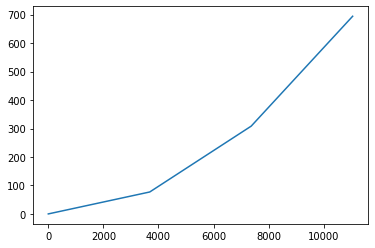

In [148]:
plt.plot(x0, z0)
plt.show()

In [149]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [150]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)

In [151]:
Re_b(Ret),Ws

(array([[[ 0.38654773,  0.65178764, -0.65249806],
         [-0.92146541,  0.24340839, -0.30274387],
         [-0.03850121,  0.71827935,  0.69468873]],
 
        [[ 0.65064878, -0.7581065 ,  0.04393971],
         [ 0.59019349,  0.54125057,  0.59893194],
         [-0.47783659, -0.36376141,  0.79959354]],
 
        [[ 0.6032021 , -0.7927714 , -0.08752563],
         [ 0.79688726,  0.59443179,  0.10780326],
         [-0.03343532, -0.13477522,  0.99031193]],
 
        [[ 0.63209824, -0.74300732,  0.21998167],
         [ 0.70610189,  0.43535703, -0.5584661 ],
         [ 0.31917383,  0.50833491,  0.79982729]]]),
 array([941.76, 941.76, 941.76, 941.76]))

In [152]:
np.einsum('it,ijk->ijk',Ws.reshape(node_N,1),Re_b(Ret))

array([[[ 364.03519321,  613.82753104, -614.49657268],
        [-867.79926717,  229.23228678, -285.11206253],
        [ -36.258897  ,  676.44675949,  654.23006012]],

       [[ 612.75499901, -713.95437486,   41.38066463],
        [ 555.82061684,  509.72813434,  564.05014721],
        [-450.00738958, -342.57594383,  753.02521182]],

       [[ 568.0716103 , -746.60039151,  -82.42814187],
        [ 750.4765459 ,  559.81208171,  101.52479911],
        [ -31.48804905, -126.92590821,  932.63616389]],

       [[ 595.28484039, -699.73457439,  207.1699346 ],
        [ 664.97851474,  410.00183604, -525.94102994],
        [ 300.58514822,  478.72948253,  753.24534438]]])

In [153]:
np.einsum('i,ijk->ijk',Ws,Re_b(Ret))

array([[[ 364.03519321,  613.82753104, -614.49657268],
        [-867.79926717,  229.23228678, -285.11206253],
        [ -36.258897  ,  676.44675949,  654.23006012]],

       [[ 612.75499901, -713.95437486,   41.38066463],
        [ 555.82061684,  509.72813434,  564.05014721],
        [-450.00738958, -342.57594383,  753.02521182]],

       [[ 568.0716103 , -746.60039151,  -82.42814187],
        [ 750.4765459 ,  559.81208171,  101.52479911],
        [ -31.48804905, -126.92590821,  932.63616389]],

       [[ 595.28484039, -699.73457439,  207.1699346 ],
        [ 664.97851474,  410.00183604, -525.94102994],
        [ 300.58514822,  478.72948253,  753.24534438]]])

In [154]:
def static_func(Q):
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])

    
    
#     C=ne(x,y,z,Ret)
#     a,b,c=C[:,0],C[:,1],C[:,2]

#     Z0=tau_force[:3]

    Z0=np.dot(Re_b(Ret),tau_force[:3])
#     Z1 = d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None)).T
    Z1 = d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T
    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
############################################################    
#     ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',Ws,Re_b(Ret)),Z).T 
#     ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
    ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
#     tmp=np.linalg.solve(Ret,np.vstack([ddx_phi, ddy_phi, ddz_phi]).T)
#     ddx, ddy, ddz = tmp[:,0],tmp[:,1],tmp[:,2]
    
#     tmp=phi(ddx_phi,ddy_phi, ddz_phi, Ret)
#     ddx, ddy, ddz = tmp[:,0],tmp[:,1],tmp[:,2]
############################################################    
#     ans_x=[]
#     ans_y=[]
#     ans_z=[]
#     RRRR=Re_b(Ret)
#     for i in range(len(RRRR)):
#         a,b,c=1/Ws*np.linalg.lstsq(RRRR[i],Z[i], rcond=None)[0]
#         ans_x.append(a)
#         ans_y.append(b)
#         ans_z.append(c)
    
#     ddx,ddy, ddz = np.array(ans_x),np.array(ans_y),np.array(ans_z)    
    
   
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
#     C3= d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T
    C3=d_me(φ,θ,ψ,Ret,  ωe,ωe(φ,θ,ψ,None,None))
    B_ =C3
    B=(B_ + C0.squeeze()
      )

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)
    A=np.einsum('ijk,ikr->ijr',A2,A3)
#     A=np.einsum('ijk,ikr->ijr', Re_b(Ret), np.einsum('ijk,ikr->ijr',A2,A3))


#############
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################




#     ans_φ=[]
#     ans_θ=[]
#     ans_ψ=[]
#     for i in range(len(A)):
#         a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
#         ans_φ.append(a)
#         ans_θ.append(b)
#         ans_ψ.append(c)
    
#     ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
    
    

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans
    

In [155]:
q0

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,    77.06804645,   308.4070593 ,   694.42189511,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

In [156]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [157]:
root

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,    77.06804645,   308.4070593 ,   694.42189511,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

In [158]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [159]:
x0

[0.0, 3684.228281487207, 7368.456562974414, 11052.68484446162]

In [160]:
x0_

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446])

In [161]:
z0

[0.0, 77.06804644731459, 308.40705929683963, 694.4218951076863]

In [162]:
z0_

array([  0.        ,  77.06804645, 308.4070593 , 694.42189511])

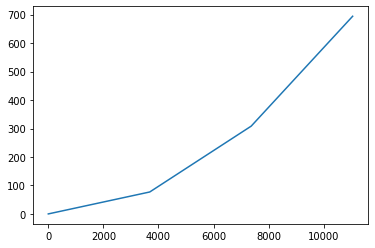

In [163]:
plt.plot(x0_, z0_)
plt.show()

In [164]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0_
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0_
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)
    elif j==9:    
        q0[(j-1)*node_N:j*node_N]=np.array([0,0,0,0.1])
    elif j==11:   
        q0[(j-1)*node_N:j*node_N]=np.array([0,0,0,0.1])

In [165]:
# q0[10*node_N]=q0[8*node_N]=0

In [166]:
q0

array([0.00000000e+00, 3.68422828e+03, 7.36845656e+03, 1.10526848e+04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 7.70680464e+01, 3.08407059e+02, 6.94421895e+02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

### Dynamics

In [174]:
# def grayscott1d(Q,p,t):
def grayscott1d(t, Q):
    print(t)
     
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
#     x[-1]=x0[-1]+10*np.sin(t)
#     x[-1]=x0_[-1]+100*np.sin(t)
#     y[-1]+=5*np.cos(t)
#     z[-1]=z0[-1]+2.5*np.sin(t)
#    z[-1]=z0_[-1]+2.5*np.sin(t)

#     x[0]=0
#     y[0]=0
#     z[0]=0

    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    
#     dx[0]=0
#     dy[0]=0
#     dz[0]=0

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
    Ret = Re_t(φ,θ,ψ)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    dη=[dx[-1],dy[-1],dz[-1],dφ[-1],dθ[-1],dψ[-1]]
    
    left=V.eq_left(η,dη)
    hack =1
    hack3=1
    
    # PD controller after 30 sec
#     if t<30:
#         ddη=np.linalg.lstsq(V.M, -left + tau(η, dη, wave_coef, Fx_0/η[0], 0, t), rcond=None)[0]
#     else:
    ddη=np.linalg.lstsq(V.M.astype(np.float32)*hack, left.astype(np.float32) 
                            - hack3*tau(η,dη, wave_coef, kp, kd, t).astype(np.float32)
                            , rcond=None)[0]
#     print('ddη', ddη)
 
    tau_force = V.tau(η,dη,ddη).astype(np.float32)
#     tau_force = hack*tau(η,dη, wave_coef, kp, kd, t) # simple motion 
#     print(tau_force)
#     tau_force = hack*tau(η,dη, wave_coef, kp, kd, t) # simple motion 
#     print(tau_force)
#     C=ne(x,y,z,Ret)
#     a,b,c=C[:,0],C[:,1],C[:,2]
#     Z0=tau_force[:3]
#     Z0=tau_force[:3]

    Z0=np.dot(Re_b(Ret),tau_force[:3])
#     print(Ret,Z0)
#     print(x,z)
   
    Z1 =d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None)).T
#     Z1 =d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T

    Z2=ne_(dx,dy,dz,DT,Ret).T
    
    Z= (Z1 + Z2 
        +Z0
       )
#     print(Z0, Z1, Z2)
############################################################    
#     ddx,ddy, ddz = 1/Ws*np.linalg.solve(Re_b(Ret),Z).T 
############################################################    
    ans_x=[]
    ans_y=[]
    ans_z=[]
    RRRR=Re_b(Ret)
#     hack2=1
#     hack4=1
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',[Ws[i] for i in range(node_N-1)]+[vessel_mass/L],RRRR),Z).T 
    
#     for i in range(len(RRRR)):
      
#         a,b,c=np.linalg.lstsq((Ws[i] + vessel_mass)*[i]
# #                               +hack2*np.identity(3)
#                               , Z[i], rcond=None)[0]
#         ans_x.append(a)
#         ans_y.append(b)
#         ans_z.append(c)
# #         print(np.dot(Ws,RRRR[i]))
    
#     ddx,ddy, ddz = np.array(ans_x),np.array(ans_y),np.array(ans_z)
    
#     print(ddx,ddy, ddz)
    
#     tmp=np.linalg.solve(Ret,np.vstack([ddx_phi, ddy_phi, ddz_phi]).T)
#     ddx, ddy, ddz = tmp[:,0],tmp[:,1],tmp[:,2]
    
    
 
    
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float32).T))
    
#     print(np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T))
#     print(np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
#                            np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)))
    C2= np.cross(np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T),
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
                           np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)))

#     C3= d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T
    C3=d_me(φ,θ,ψ,Ret, ωe, ωe(φ,θ,ψ,None,None))
#     print(d_s(phi,x,y,z,Ret).T)
#     print(d_s(phi,x,y,z,Ret, phi(x,y,z,Ret,None)))
    C4= np.cross(d_s(phi,x,y,z,Ret, phi(x,y,z,Ret,None)).T, ne(x,y,z,Ret, phi(x,y,z,Ret,None)))

    K1=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T).T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float32).T)
#     print(np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)).shape)

#     C0=np.einsum('ijk,kp->ijp',
#                  np.linalg.inv(Π(φ,θ,ψ)), tau_force[3:].reshape(3,1)
#                 ) 
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
#     print(C1.shape,C2.shape,C3.shape,C4.shape,C5.shape)
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0.squeeze()
       

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)

    A=np.einsum('ijk,ikr->ijr',A2,A3)
#     A=np.einsum('ijk,ikr->ijr', Re_b(Ret), np.einsum('ijk,ikr->ijr',A2,A3))

############################################
#     ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################

    ans_φ=[]
    ans_θ=[]
    ans_ψ=[]
    hack5=1
    for i in range(len(A)):
#         if i==len(A)-1:
#             hack5=vessel_inertia_coef
        a,b,c=np.linalg.lstsq(A[i]
#                               +hack2*np.identity(3)
                              ,B[i], rcond=None)[0]
        ans_φ.append(a)
        ans_θ.append(b)
        ans_ψ.append(c)
    
    ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
    ddφ*=np.exp(-t)
    ddθ*=np.exp(-t)
    ddψ*=np.exp(-t)
#     ddx[-1],ddy[-1],ddz[-1],ddφ[-1],ddθ[-1],ddψ[-1]=ddη
#     print(ddφ,ddθ,ddψ)

    ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
#     A1111=np.concatenate([dx, ddx, 
#                           np.zeros(node_N), np.zeros(node_N),
#                           dz, ddz,
#                           np.zeros(node_N),  np.zeros(node_N),
#                           np.zeros(node_N), np.zeros(node_N),
#                           np.zeros(node_N),  np.zeros(node_N),
#                           ], axis=0)

        

#     print(A1111)
    return A1111

In [175]:
# ode15s = scipy.integrate.ode(grayscott1d)
# # ode15s.set_integrator('vode', method='bdf', order=15, nsteps=3000)
# ode15s.set_integrator('vode',  order=15, nsteps=3000)
# ode15s.set_initial_value(q0, 0)

In [176]:
# us=ode15s.integrate(10)

In [177]:
tspan = (0., 1)
# tspan = (0., 10)

In [178]:
startTime1 = datetime.now()
# prob = de.ODEProblem(grayscott1d, q0, tspan)
# us = de.solve(prob)
us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1e9, atol=1e9
            )
# us=ode15s.integrate(10)
print(datetime.now() - startTime1)

0.0
5.403087503022304e-13
1.080617500604461e-11
1.6209262509066913e-11
4.322470002417844e-11
4.8027444471309366e-11
5.403087503022304e-11
5.403087503022304e-11
1.6209262509066912e-10
2.1612350012089217e-10
4.862778752720073e-10
5.343053197433167e-10
5.943396253324534e-10
5.943396253324534e-10
1.674957125936914e-09
2.2152658762391445e-09
4.9168096277502965e-09
5.3970840724633905e-09
5.9974271283547575e-09
5.9974271283547575e-09
1.6803602134399368e-08
2.220668963742167e-08
4.9222127152533197e-08
5.4024871599664126e-08
6.00283021585778e-08
6.00283021585778e-08
1.6809005221902387e-07
2.2212092724924692e-07
4.922753024003621e-07
5.403027468716715e-07
6.003370524608082e-07
6.003370524608082e-07
1.6809545530652688e-06
2.221263303367499e-06
4.922807054878651e-06
5.403081499591744e-06
6.003424555483111e-06
6.003424555483111e-06
1.680959956152772e-05
2.2212687064550022e-05
4.922812457966154e-05
5.403086902679247e-05
6.0034299585706145e-05
6.0034299585706145e-05
8.014743366511478e-05
9.0204000704

0.011062713249506842
0.01108572752484253
0.011200798901520979
0.011221256035152704
0.011246827452192359
0.011246827452192359
0.011290628930612867
0.011312529669823122
0.011422033365874393
0.011441500689616841
0.0114658348442949
0.0114658348442949
0.01128572698239579
0.011305176747497505
0.011402425573006083
0.011419714253096498
0.011441325103209514
0.011441325103209514
0.011480224633412946
0.01149967439851466
0.011596923224023238
0.011614211904113653
0.01163582275422667
0.01163582275422667
0.011678814157209528
0.011700309858700955
0.011807788366158098
0.011826895656372701
0.011850779769140956
0.011850779769140956
0.011896671154666139
0.01191961684742873
0.012034345311241689
0.012054741482586213
0.012080236696766871
0.012080236696766871
0.012123893236969965
0.012145721507071511
0.012254862857579244
0.012274265764336174
0.012298519397782337
0.012298519397782337
0.01211916407364327
0.012138627762081472
0.012235946204272471
0.012253247260661982
0.01227487358114887
0.01227487358114887
0.012

0.022687032407929006
0.022708278395217524
0.022708278395217524
0.022746521172336852
0.02276564256089652
0.022861249503694843
0.022878246293525653
0.02289949228081417
0.02289949228081417
0.022942967863761307
0.022964705655234875
0.023073394612602712
0.02309271709391255
0.02311687019554985
0.02311687019554985
0.023164146365854135
0.023187784451006277
0.023305974876766992
0.023326986508013344
0.02335325104707128
0.02335325104707128
0.023397629657096495
0.023419818962109103
0.023530765487172145
0.02355048931385002
0.02357514409719736
0.02357514409719736
0.02339158231068091
0.023410747942485724
0.023506576101509802
0.023523612218669637
0.02354490736511943
0.02354490736511943
0.02358323862872906
0.023602404260533876
0.023698232419557954
0.02371526853671779
0.023736563683167584
0.023736563683167584
0.02378000930671166
0.023801732118483698
0.023910346177343885
0.023929655343363474
0.023953791800887962
0.023953791800887962
0.024000943386327973
0.02402451917904798
0.02414239814264801
0.024163354

0.03396018741212547
0.03397939429179055
0.0340034028913719
0.0340034028913719
0.03404956029640992
0.03407263899892892
0.03418803251152395
0.034208546913763065
0.03423418991656196
0.03423418991656196
0.03427810555143777
0.03430006336887567
0.03440985245606518
0.034429370516009986
0.03445376809094099
0.03445376809094099
0.03427332778754251
0.03429289672303279
0.03439074140048416
0.03440813600980885
0.03442987927146471
0.03442987927146471
0.034469017142445255
0.034488586077935535
0.03458643075538691
0.03460382536471159
0.03462556862636745
0.03462556862636745
0.034668769389543025
0.03469036977113082
0.03479837167906975
0.03481757201825889
0.034841572442245325
0.034841572442245325
0.03488766705829079
0.034910714366313524
0.03502595090642718
0.035046437402447395
0.03507204552247265
0.03507204552247265
0.035115936954789956
0.03513788267094861
0.035247611251741875
0.03526711855499401
0.03529150268405918
0.03529150268405918
0.035111234214457304
0.035130828560449634
0.035228800290411276
0.035246

0.04595275655886777
0.04595275655886777
0.04599642752629439
0.04601826301000771
0.046127440428574265
0.04614684974743054
0.046171111396000886
0.046171111396000886
0.04621849942616246
0.04624219344124326
0.04636066351664721
0.04638172486338568
0.046408051546808785
0.046408051546808785
0.04645260553765028
0.04647488253307102
0.04658626751017475
0.046606069283882084
0.046630821501016245
0.046630821501016245
0.04644667606915718
0.04646598833033137
0.04656254963620235
0.04657971609057941
0.046601174158550744
0.046601174158550744
0.04663979868089914
0.04665911094207333
0.04675567224794431
0.04677283870232137
0.046794296770292704
0.046794296770292704
0.046837938771187186
0.046859759771634424
0.04696886477387062
0.046988261218712614
0.0470125067747651
0.0470125067747651
0.047059778730884815
0.04708341470894467
0.04720159459924396
0.047222604357519384
0.04724886655536367
0.04724886655536367
0.04729337135635916
0.0473156237568569
0.04742688575934561
0.04744666567089916
0.047471390560341095
0.047

0.05756802346437838
0.057386915212430285
0.05740661729246234
0.0575051276926226
0.057522640652651086
0.0575445318526867
0.0575445318526867
0.0575839360127508
0.057603638092782856
0.05770214849294312
0.0577196614529716
0.05774155265300722
0.05774155265300722
0.05778495666383147
0.05780665866924359
0.0579151686963042
0.057934459367781646
0.057958572707128446
0.057958572707128446
0.05800482601329989
0.058027952666385614
0.058143585931814235
0.05816414295677932
0.05818983923798568
0.05818983923798568
0.05823392733996568
0.058255971390955674
0.05836619164590566
0.05838578635789677
0.05841027974788566
0.05841027974788566
0.05822929291004518
0.05824901974607494
0.058347653926223694
0.05836518889158347
0.058387107598283194
0.058387107598283194
0.058426561270342695
0.05844628810637245
0.05854492228652121
0.05856245725188099
0.05858437595858071
0.05858437595858071
0.058627764379792904
0.058649458590398995
0.05875792964342948
0.058777213386190456
0.05880131806464167
0.05880131806464167
0.05884750

0.06978623853588932
0.06981106214434317
0.06981106214434317
0.06962661433062657
0.06964609666181064
0.06974350831773092
0.06976082594545008
0.06978247298009903
0.06978247298009903
0.06982143764246714
0.0698409199736512
0.06993833162957148
0.06995564925729064
0.06997729629193959
0.06997729629193959
0.07002109837845295
0.07004299942170963
0.07015250463799302
0.07017197223199896
0.07019630672450639
0.07019630672450639
0.0702436014875629
0.07026724886909115
0.07038548577673241
0.0704065056714242
0.07043278053978892
0.07043278053978892
0.07047741832182616
0.07049973721284479
0.0706113316679379
0.07063117068217667
0.07065596944997514
0.07065596944997514
0.07047181646247809
0.07049133442382269
0.07058892423054562
0.07060627352951858
0.07062796015323479
0.07062796015323479
0.07066699607592396
0.07068651403726856
0.07078410384399149
0.07080145314296445
0.07082313976668066
0.07082313976668066
0.0708669204679862
0.07088881081863899
0.07099826257190288
0.071017720661372
0.07104204327320843
0.07104

0.08187087944363951
0.08189266113557561
0.08200156959525616
0.08202093109919938
0.08204513297912838
0.08204513297912838
0.08209138922096124
0.08211451734187768
0.08223015794645983
0.08225071627616332
0.08227641418829268
0.08227641418829268
0.08232062419458251
0.08234272919772742
0.08245325421345201
0.08247290310513639
0.08249746421974184
0.08249746421974184
0.08253727399689137
0.08255717888546613
0.08265670332833992
0.08267439656262861
0.08269651310548945
0.08269651310548945
0.08273467648050431
0.08275375816801174
0.08284916660554888
0.08286612810555548
0.08288732998056374
0.08288732998056374
0.08292853216228167
0.08294913325314064
0.08305213870743548
0.08307045078819901
0.08309334088915342
0.08309334088915342
0.08313931196924175
0.08316229750928592
0.08327722520950674
0.08329765680065711
0.08332319628959507
0.08332319628959507
0.08336988120732695
0.08339322366619288
0.08350993596052257
0.08353068481284785
0.08355662087825445
0.08355662087825445
0.08359864949225136
0.0836196637992498
0

0.09435069343857591
0.09435069343857591
0.09439783033334118
0.09442139878072381
0.09453924101763697
0.09456019074864376
0.09458637791240224
0.09458637791240224
0.09463106504966734
0.0946534086182999
0.09476512646146268
0.09478498741135828
0.09480981359872778
0.09480981359872778
0.09462585720722475
0.09464559685463599
0.09474429509169224
0.09476184144494669
0.09478377438651475
0.09478377438651475
0.09482325368133726
0.0948429933287485
0.09494169156580476
0.0949592379190592
0.09498117086062727
0.09498117086062727
0.09502506406804846
0.09504701067175905
0.09515674369031202
0.09517625178249922
0.09520063689773321
0.09520063689773321
0.09524768955219876
0.09527121587943152
0.09538884751559537
0.09540975980646894
0.09543590017006091
0.09543590017006091
0.0954805455954555
0.0955028683081528
0.09561448187163928
0.09563432428292576
0.09565912729703387
0.09565912729703387
0.0954754334815526
0.09549520013729845
0.0955940334160277
0.09561160377669066
0.09563356672751938
0.09563356672751938
0.09567

0.106265643359192
0.10630441422839845
0.10632379966300169
0.10642072683601783
0.10643795833344291
0.10645949770522428
0.10645949770522428
0.10650385825160405
0.10652603852479393
0.10663693989074335
0.10665665568913436
0.10668130043712312
0.10668130043712312
0.10672977810973025
0.10675401694603381
0.10687521112755165
0.10689675675982148
0.10692368880015878
0.10692368880015878
0.10696908891062246
0.10699178896585429
0.10710528924201347
0.10712546706888622
0.10715068935247715
0.10715068935247715
0.1069626078456321
0.10698206736836877
0.10707936498205207
0.10709666233559577
0.10711828402752539
0.10711828402752539
0.10715720307299871
0.10717666259573538
0.10727396020941869
0.10729125756296239
0.10731287925489201
0.10731287925489201
0.10735722191621919
0.10737939324688278
0.10749024990020072
0.10750995774967946
0.10753459256152789
0.10753459256152789
0.10758288498624181
0.10760703119859877
0.10772776226038355
0.10774922556025641
0.10777605468509747
0.10777605468509747
0.10782134194674572
0.1

0.11836932727084792
0.1183870499935521
0.1184092033969323
0.1184092033969323
0.1184532056113829
0.1184752067186082
0.11858521225473469
0.11860476879449051
0.11862921446918528
0.11862921446918528
0.11867616169394096
0.1186996353063188
0.118817003368208
0.11883786880143274
0.11886395059296367
0.11886395059296367
0.11890866669893499
0.11893102475192065
0.11904281501684894
0.11906268884172508
0.11908753112282025
0.11908753112282025
0.11890388137422614
0.11892384676485737
0.11902367371801352
0.11904142073190795
0.11906360449927599
0.11906360449927599
0.11910353528053845
0.11912350067116968
0.11922332762432583
0.11924107463822026
0.1192632584055883
0.1192632584055883
0.11930724352344807
0.11932923608237796
0.1194391988770274
0.11945874781829842
0.11948318399488718
0.11948318399488718
0.11953005733402586
0.1195534940035952
0.1196706773514419
0.11969150994661465
0.11971755069058058
0.11971755069058058
0.11976223227699444
0.11978457307020136
0.11989627703623601
0.11991613551908661
0.11994095862

0.13078285625791208
0.13080476994833656
0.13080476994833656
0.13084914825012522
0.13087133740101956
0.13098228315549124
0.13100200684517507
0.1310266614572799
0.1310266614572799
0.1310746146093495
0.13109859118538428
0.13121847406555825
0.1312397865775892
0.13126642721762785
0.13126642721762785
0.13131167746733088
0.1313343025921824
0.13144742821643998
0.1314675394385302
0.13149267846614301
0.13149267846614301
0.1313059551402205
0.13132571910151683
0.13142453890799843
0.13144210687359517
0.1314640668305911
0.1314640668305911
0.13150359475318374
0.13152335871448007
0.13162217852096167
0.1316397464865584
0.13166170644355432
0.13166170644355432
0.13170605661576495
0.13172823170187029
0.1318391071323969
0.13185881832004606
0.13188345730460754
0.13188345730460754
0.13193129320576116
0.13195521115633796
0.13207480090922202
0.13209606130973475
0.13212263681037564
0.13212263681037564
0.13216783770018695
0.1321904381450926
0.13230344036962088
0.13232352965398145
0.1323486412594322
0.13234864125

0.14319025505603658
0.14320878744579912
0.1432319529330023
0.1432319529330023
0.14327847196138885
0.14330173147558212
0.14341802904654843
0.1434387041702758
0.14346454807493497
0.14346454807493497
0.14351182803756954
0.1435354680188868
0.1436536679254732
0.14367468124219968
0.14370094788810778
0.14370094788810778
0.14374354772309977
0.14376484764059577
0.1438713472280758
0.14389028048807223
0.1439139470630678
0.1439139470630678
0.14373913649841796
0.14375823080357306
0.14385370232934852
0.14387067504504195
0.1438918909396587
0.1438918909396587
0.1439300795499689
0.14394917385512399
0.14404464538089945
0.14406161809659287
0.14408283399120964
0.14408283399120964
0.1441272787667119
0.14414950115446304
0.14426061309321872
0.1442803663267753
0.144305057868721
0.144305057868721
0.14435476168716724
0.14437961359639034
0.14450387314250596
0.14452596372848206
0.1445535769609522
0.1445535769609522
0.14460029828640802
0.14462365894913595
0.14474046226277557
0.1447612272963115
0.1447871835882314
0

0.1552461082441569
0.1552683669729551
0.1552683669729551
0.15531274953065
0.15533494080949745
0.1554458972037347
0.15546562278493242
0.1554902797614296
0.1554902797614296
0.15553775664483316
0.15556149508653494
0.15568018729504388
0.15570128813211212
0.15572766417844744
0.15572766417844744
0.15577280364941376
0.1557953733848969
0.1559082220623127
0.15592828404940884
0.15595336153327902
0.15595336153327902
0.15576779277906266
0.15578785707937026
0.15588817858090828
0.15590601351451505
0.1559283071815235
0.1559283071815235
0.15596843578213873
0.15598850008244633
0.15608882158398435
0.15610665651759112
0.15612895018459957
0.15612895018459957
0.15617331145603153
0.15619549209174752
0.15630639527032744
0.15632611139096386
0.1563507565417594
0.1563507565417594
0.15639814431937837
0.15642183820818786
0.15654030765223534
0.15656136888673267
0.15658769542985432
0.15658769542985432
0.15663279576568223
0.1566553459335962
0.15676809677316603
0.1567881413668673
0.15681319710899394
0.156813197108993

0.16805201333023131
0.1681730518706874
0.16819456983343517
0.16822146728686985
0.16822146728686985
0.16826710569705539
0.16828992490214817
0.168404020927612
0.16842430466547223
0.16844965933779754
0.16844965933779754
0.16826122787416659
0.16828110816781494
0.16838050963605675
0.16839818100818862
0.16842027022335349
0.16842027022335349
0.16846003081065022
0.16847991110429858
0.16857931257254039
0.16859698394467226
0.16861907315983712
0.16861907315983712
0.16866377791676507
0.16868613029522905
0.16879789218754895
0.1688177609684058
0.1688425969444769
0.1688425969444769
0.16889088194873095
0.168915024450858
0.1690357369614931
0.16905719696338378
0.16908402196574715
0.16908402196574715
0.16912960021069537
0.16915238933316948
0.16926633494554005
0.16928659194329482
0.16931191319048827
0.16931191319048827
0.1691238645815809
0.1691437858894978
0.1692433924290822
0.16926110025834165
0.16928323504491596
0.16928323504491596
0.16932307766074972
0.1693429989686666
0.16944260550825102
0.16946031333

0.1805563457570821
0.1805801617280564
0.18069924158292808
0.18072041133490527
0.18074687352487676
0.18074687352487676
0.18078979584738802
0.18081125700864367
0.18091856281492186
0.18093763940270463
0.18096148513743313
0.18096148513743313
0.18078534046693626
0.180804573937966
0.18090074129311473
0.18091783771180783
0.18093920823517423
0.18093920823517423
0.18097767517723373
0.18099690864826348
0.1810930760034122
0.1811101724221053
0.1811315429454717
0.1811315429454717
0.18117630680369945
0.1811986887328133
0.18131059837838265
0.18133049342648386
0.1813553622366104
0.1813553622366104
0.1814054266070154
0.18143045879221792
0.18155561971823045
0.18157787054952154
0.18160568408863545
0.18160568408863545
0.18165274863290137
0.18167628090503432
0.1817939422656991
0.1818148598409284
0.181841006809965
0.181841006809965
0.18164515290666708
0.1816648873156829
0.181763559360762
0.18178110105766493
0.18180302817879362
0.18180302817879362
0.18184249699682525
0.18186223140584107
0.18196090345092017
0

0.1926213346983281
0.1926691197021951
0.1926930122041286
0.1928124747137961
0.19283371249329254
0.1928602597176631
0.1928602597176631
0.19290571454865035
0.19292844196414397
0.19304207904161208
0.19306228118871752
0.19308753387259933
0.19308753387259933
0.19290070201575463
0.1929209231648004
0.19302202891002923
0.19304000326473658
0.19306247120812076
0.19306247120812076
0.19310291350621228
0.19312313465525804
0.19322424040048689
0.19324221475519424
0.1932646826985784
0.1932646826985784
0.19330935021911674
0.1933316839793859
0.19344335278073177
0.19346320501208214
0.1934880203012701
0.1934880203012701
0.19353570934088418
0.1935595538606912
0.19367877645972637
0.19369997158844374
0.19372646549934044
0.19372646549934044
0.19377187375764998
0.19379457788680476
0.19390809853257862
0.19392827998071618
0.19395350679088816
0.19395350679088816
0.19376696987945957
0.19378722206951915
0.19388848301981698
0.1939064849665366
0.1939289873999361
0.1939289873999361
0.19396949178005524
0.19398974397011

0.20495195808199398
0.2049741732923054
0.2049741732923054
0.20501921036750473
0.20504172890510441
0.20515432159310273
0.2051743380709691
0.20519935866830205
0.20519935866830205
0.20524805990614883
0.2052724105250722
0.20539416361968912
0.2054158086142877
0.2054428648575359
0.2054428648575359
0.20548880002150643
0.20551176760349169
0.205626605513418
0.20564702114184935
0.20567254067738852
0.20567254067738852
0.20548294194712657
0.2055029804919219
0.20560317321589852
0.2056209852557166
0.2056432503054892
0.2056432503054892
0.20568332739507986
0.20570336593987518
0.2058035586638518
0.20582137070366988
0.20584363575344247
0.20584363575344247
0.20588864144206306
0.20591114428637336
0.20602365850792484
0.20604366103620067
0.20606866419654543
0.20606866419654543
0.20611723781206603
0.20614152461982635
0.2062629586586279
0.20628454693219261
0.2063115322741485
0.2063115322741485
0.2063574123008973
0.2063803523142717
0.20649505238114368
0.20651544350414314
0.20654093240789248
0.20654093240789248

0.21757397597858152
0.2176190605774395
0.21764160287686848
0.21775431437401344
0.21777435197350586
0.2177993989728714
0.2177993989728714
0.21784985849075297
0.21787508824969376
0.21800123704439772
0.21802366349678953
0.2180516965622793
0.2180516965622793
0.21809910930367551
0.2181228156743736
0.21824134752786412
0.21826241985737355
0.21828876026926033
0.21828876026926033
0.2180914106955208
0.21811126776214154
0.21821055309524526
0.21822820382113037
0.21825026722848676
0.21825026722848676
0.21828998136172825
0.218309838428349
0.21840912376145272
0.21842677448733783
0.21844883789469421
0.21844883789469421
0.21849435409401172
0.21851711219367048
0.21863090269196422
0.21865113211388312
0.21867641889128173
0.21867641889128173
0.2187260354224709
0.2187508436880655
0.2188748850160384
0.21889693680767805
0.2189245015472276
0.2189245015472276
0.21897077817300079
0.21899391648588737
0.21910960805032034
0.21913017543955288
0.21915588467609354
0.21915588467609354
0.21896413181050364
0.218983946942

0.2304391955387473
0.23045952526433275
0.23048493742131457
0.23048493742131457
0.23029697176708852
0.23031734364639367
0.23041920304291938
0.2304373113800795
0.23045994680152965
0.23045994680152965
0.23050069056013991
0.23052106243944506
0.23062292183597077
0.2306410301731309
0.23066366559458104
0.23066366559458104
0.23070863858063784
0.23073112507366622
0.23084355753880823
0.23086354553261124
0.23088853052486502
0.23088853052486502
0.23093652018466324
0.23096051501456233
0.23108048916405782
0.23110181790174592
0.23112847882385604
0.23112847882385604
0.2311741830549058
0.2311970351704307
0.2313112957480551
0.23133160873963277
0.23135699997910486
0.23135699997910486
0.23116928160422817
0.23118968299441425
0.23129168994534463
0.2313098245143989
0.23133249272571677
0.23133249272571677
0.2313732955060889
0.23139369689627498
0.23149570384720536
0.23151383841625964
0.2315365066275775
0.2315365066275775
0.23158145848085604
0.2316039344074953
0.23171631404069162
0.23173629264214876
0.231761265

0.24329143267395603
0.24330937695815885
0.24333180731341236
0.24333180731341236
0.24337712217969915
0.2433997796128425
0.24351306677855944
0.24353320671913134
0.24355838164484622
0.24355838164484622
0.24360726465831026
0.2436317061650423
0.24375391369870242
0.2437756394824642
0.24380279671216645
0.24380279671216645
0.2438489749093794
0.24387206400798586
0.2439875095010182
0.24400803314422395
0.24403368769823114
0.24403368769823114
0.24384324861628714
0.24386347456834748
0.2439646043286492
0.24398258295270284
0.24400505623276988
0.24400505623276988
0.24404550813689058
0.2440657340889509
0.24416686384925262
0.24418484247330627
0.24420731575337332
0.24420731575337332
0.2442526037152036
0.24427524769611875
0.2443884676006945
0.24440859558373018
0.24443375556252478
0.24443375556252478
0.24448252250603672
0.24450690597779268
0.24462882333657254
0.24465049753368895
0.24467759028008448
0.24467759028008448
0.24472370934749693
0.24474676888120317
0.24486206654973428
0.2448825639130287
0.24490818

0.25577510432762796
0.2557926558410806
0.2558145952328963
0.2558145952328963
0.25585721631513775
0.25587852685625845
0.2559850795618621
0.25600402226508057
0.2560277006441036
0.2560277006441036
0.25607524168245793
0.2560990122016351
0.256217864797521
0.25623899414790074
0.25626540583587537
0.25626540583587537
0.256313688332031
0.25633782958010876
0.25645853582049777
0.25647999470767807
0.2565068183166534
0.2565068183166534
0.2565503007817887
0.25657204201435635
0.25668074817719466
0.2567000737172548
0.25672423064232996
0.25672423064232996
0.256545827997466
0.2565653328378723
0.2566628570399038
0.25668019467582054
0.25670186672071643
0.25670186672071643
0.25674087640152904
0.25676038124193534
0.25685790544396686
0.2568752430798836
0.25689691512477947
0.25689691512477947
0.2569423203310661
0.2569650229342094
0.2570785359499261
0.25709871604160905
0.25712394115621273
0.25712394115621273
0.25717471801896963
0.25720010645034813
0.2573270486072404
0.257349616101799
0.2573778254699973
0.25737

0.26850490162509527
0.26852508316673435
0.26855031009378316
0.26855031009378316
0.26859900757616434
0.2686233563173549
0.26874510002330787
0.2687667433488106
0.26879379750568905
0.26879379750568905
0.26883997582408203
0.26886306498327855
0.26897851077926105
0.2689990344763246
0.26902468909765404
0.26902468909765404
0.2688346544393581
0.26885508290619264
0.2689572252403653
0.26897538387755154
0.26899808217403437
0.26899808217403437
0.26903893910770343
0.26905936757453797
0.26916150990871063
0.26917966854589687
0.2692023668423797
0.2692023668423797
0.26924775553569075
0.2692704498823463
0.26938392161562386
0.26940409436820656
0.2694293103089349
0.2694293103089349
0.2694779389595355
0.26950225328483574
0.26962382491133713
0.26964543764493737
0.2696724535619377
0.2696724535619377
0.26971860740037285
0.2697416843195904
0.26985706891567823
0.26987758173276055
0.2699032227541134
0.2699032227541134
0.2697133642470815
0.26973381958965337
0.2698360963025129
0.26985427882924345
0.2698770069876566

0.28137689997887416
0.28150239648804676
0.28152470697856635
0.2815525950917158
0.2815525950917158
0.2815993682579805
0.2816227548411128
0.28173968775677444
0.2817604758306699
0.2817864609230391
0.2817864609230391
0.28159264538323386
0.28161267052899286
0.2817127962577879
0.2817305963873515
0.28175284654930594
0.28175284654930594
0.281792896840824
0.281812921986583
0.281913047715378
0.2819308478449416
0.28195309800689605
0.28195309800689605
0.28199901084151235
0.28202196725882056
0.28213674934536137
0.2821571550496353
0.2821826621799777
0.2821826621799777
0.28223287706243344
0.28225798450366135
0.28238352170980074
0.28240583943533665
0.2824337365922565
0.2824337365922565
0.2824806989688
0.2825041801570718
0.2826215860984306
0.2826424582657832
0.2826685484749741
0.2826685484749741
0.2824739199349034
0.2824940116062268
0.28259446996284393
0.2826123292262426
0.2826346533054908
0.2826346533054908
0.2826748366481377
0.2826949283194611
0.28279538667607823
0.2828132459394769
0.2828355700187251

0.2943108609492598
0.2943108609492598
0.2943565475088443
0.2943793907886366
0.29449360718759804
0.29451391232519114
0.2945392937471826
0.2945392937471826
0.29458839170973183
0.2946129406910064
0.2947356855973795
0.2947575069140681
0.29478478355992876
0.29478478355992876
0.2948312382240219
0.2948544655560685
0.2949706022163014
0.2949912487336761
0.29501705688039453
0.29501705688039453
0.2948257196324962
0.29484618766877996
0.29494852785019865
0.29496672166022864
0.2949894639227661
0.2949894639227661
0.29503039999533354
0.2950508680316173
0.295153208213036
0.29517140202306597
0.2951941442856034
0.2951941442856034
0.2952398258029849
0.2952626665616757
0.2953768703551295
0.2953971732517435
0.295422551872511
0.295422551872511
0.2954716113853852
0.29549614114182227
0.29561878992400775
0.2956405941519519
0.29566784943688196
0.29566784943688196
0.2957142872208885
0.2957375061128918
0.29585360057290816
0.29587423958802217
0.2959000383569147
0.2959000383569147
0.29570881718981945
0.2957293010662

0.3071319663753085
0.30715906275320953
0.30715906275320953
0.3072054030030231
0.30722857312792995
0.307344423752464
0.3073650194190478
0.3073907640022776
0.3073907640022776
0.30720033189162976
0.30722096646083985
0.3073241393068904
0.3073424811461883
0.30736540844531063
0.30736540844531063
0.30740667758373086
0.30742731215294095
0.3075304849989915
0.3075488268382894
0.3075717541374117
0.3075717541374117
0.307617421980804
0.30764025590250016
0.30775442551098087
0.3077747223302663
0.30780009335437314
0.30780009335437314
0.3078488703413741
0.30787325883487454
0.3079952013023769
0.3080168799632662
0.30804397828937785
0.30804397828937785
0.308090329874126
0.3081135056665001
0.3082293846283705
0.30824998533270304
0.30827573621311866
0.30827573621311866
0.3080852638660313
0.308105906654358
0.30820912059599165
0.30822746974117093
0.3082504061726451
0.3082504061726451
0.30829169174929855
0.3083123345376253
0.3084155484792589
0.3084338976244382
0.30845683405591234
0.30845683405591234
0.308502506

0.31979319055958416
0.31960243612451494
0.31962311915082176
0.31972653428235576
0.3197449191946285
0.3197679003349694
0.3197679003349694
0.319809266387583
0.3198299494138898
0.3199333645454238
0.31995174945769655
0.31997473059803744
0.31997473059803744
0.3200205109967809
0.32004340119615265
0.3201578521930113
0.3201781990368973
0.32020363259175477
0.32020363259175477
0.3202525211071069
0.3202769653647829
0.32039918665316314
0.32042091488220853
0.32044807516851526
0.32044807516851526
0.32049451281265073
0.32051773163471853
0.3206338257450573
0.32065446469800635
0.32068026338919275
0.32068026338919275
0.32048944033623483
0.32051012292009456
0.32061353583939345
0.32063192035837995
0.320654901007113
0.320654901007113
0.3206962661748326
0.32071694875869233
0.3208203616779912
0.3208387461969777
0.3208617268457108
0.3208617268457108
0.320907520293739
0.32093041701775304
0.3210449006378235
0.32106525328139157
0.32109069408585167
0.32109069408585167
0.3211396012825035
0.32116405488082944
0.3212

0.332177406565197
0.332200316742895
0.332200316742895
0.3322415550627515
0.3322621742226797
0.3323652700223208
0.33238359816447927
0.3324065083421773
0.3324065083421773
0.33245252927212166
0.3324755397370938
0.33259059206195474
0.3326110458085967
0.3326366129918991
0.3326366129918991
0.33268599861907117
0.33271069143265725
0.3328341555005874
0.3328561046682194
0.3328835411277595
0.3328835411277595
0.3329302330623774
0.33295357902968636
0.33307030886623124
0.33309106083717255
0.33311700080084916
0.33311700080084916
0.33292475721717124
0.3329453652618771
0.3330484054854065
0.3330667237473673
0.33308962157481825
0.33308962157481825
0.33313083766423
0.3331514457089359
0.33325448593246526
0.33327280419442606
0.333295702021877
0.333295702021877
0.3333417385126195
0.33336475675799077
0.33347984798484703
0.3335003086473992
0.3335258844755895
0.3335258844755895
0.33357531807505364
0.3336000348747857
0.3337236188734459
0.33374558936209664
0.33377305247291006
0.33377305247291006
0.333819774271000

0.34491725487596236
0.3449404293599709
0.3450563017800135
0.3450769013213544
0.34510265074803054
0.34510265074803054
0.3451528224906084
0.3451779083618974
0.34530333771834215
0.345325636270599
0.34535350946092
0.34535350946092
0.3454005804452661
0.3454241159374392
0.3455417933983045
0.3455627138357916
0.3455888643826506
0.3455888643826506
0.3453944140390945
0.3454148663281817
0.3455171277736178
0.3455353075861398
0.3455580323517923
0.3455580323517923
0.34559893692996674
0.34561938921905394
0.34572165066449007
0.34573983047701207
0.3457625552426645
0.3457625552426645
0.3458089263056624
0.34583211183716134
0.3459480394946561
0.34596864885598844
0.34599441055765395
0.34599441055765395
0.34604464624751013
0.3460697640924382
0.3461953533170786
0.34621768029034805
0.3462455890069348
0.3462455890069348
0.3462926923232166
0.34631624398135746
0.34643400227206184
0.3464549370792982
0.3464811055883436
0.3464811055883436
0.3462864677044784
0.3463069070532502
0.3464091037971092
0.3464272721071286
0

0.35847231263783524
0.3584982422056686
0.3584982422056686
0.35854921272080365
0.35857469797837116
0.3587021242662087
0.35872477782849094
0.3587530947813437
0.3587530947813437
0.3588005525455958
0.3588242814277218
0.358942925838352
0.3589640181780196
0.3589903836026041
0.3589903836026041
0.35879370736380584
0.3588140136550369
0.3589155451111923
0.3589335951478421
0.3589561576936544
0.3589561576936544
0.35899677027611654
0.3590170765673476
0.359118608023503
0.3591366580601528
0.3591592206059651
0.3591592206059651
0.3592059062010793
0.3592292489986364
0.35934596298642185
0.3593667121398059
0.359392648581536
0.359392648581536
0.359443642109042
0.359469138872795
0.35959662269156
0.35961928648156266
0.359647616219066
0.359647616219066
0.359695084193049
0.35971881818004053
0.35983748811499805
0.35985858499232387
0.3598849560889811
0.3598849560889811
0.3596882286828469
0.35970853491473737
0.3598100660741897
0.3598281160580923
0.3598506785379706
0.3598506785379706
0.3598912910017515
0.359911597

0.37197826226158026
0.3720035818792725
0.37213017996773373
0.3721526862945713
0.37218081920311824
0.37218081920311824
0.37222818602117363
0.37225186943020133
0.3723702864753399
0.3723913383944756
0.37241765329339527
0.37241765329339527
0.3722217956610808
0.3722422838900621
0.37234472503496846
0.37236293679406296
0.37238570149293104
0.37238570149293104
0.3724266779508936
0.3724471661798749
0.37254960732478126
0.37256781908387576
0.37259058378274384
0.37259058378274384
0.37263717491598575
0.3726604704826067
0.37277694831571145
0.3727976554860412
0.37282353944895336
0.37282353944895336
0.3728740746901562
0.37289934231075766
0.3730256804137649
0.37304814052096613
0.37307621565496774
0.37307621565496774
0.3731235136776487
0.3731471626889892
0.37326540774569156
0.3732864290891053
0.3733127057683725
0.3733127057683725
0.3731172430132007
0.3731377566923172
0.37324032508789956
0.37325855946933645
0.37328135244613253
0.37328135244613253
0.3733223798043655
0.373342893483482
0.37344546187906436
0.

0.3850678308158576
0.38508799604515376
0.3851888221916344
0.38520674683989764
0.38522915265022667
0.38522915265022667
0.38528093116652895
0.38530682042468006
0.3854362667154357
0.3854592793893478
0.38548804523173796
0.38548804523173796
0.38555538388298144
0.3855890532086032
0.385757399836712
0.3857873281261535
0.38582473848795545
0.38582473848795545
0.38554798750748753
0.38557795864536226
0.38572781433473613
0.3857544553461804
0.3857877566104857
0.3857877566104857
0.38584769888623527
0.38587767002411
0.38602752571348387
0.38605416672492815
0.38608746798923343
0.38608746798923343
0.3858325194431414
0.3858549008594693
0.3859668079411085
0.3859867025333999
0.3860115707737642
0.3860115707737642
0.3860563336064199
0.3860787150227477
0.386190622104387
0.3862105166966784
0.3862353849370427
0.3862353849370427
0.38628423247002724
0.38630865623651955
0.38643077506898105
0.38645248508364083
0.3864796226019656
0.3864796226019656
0.3865297559039914
0.3865548225550043
0.3866801558100687
0.3867024372

0.39855399337414965
0.39857487270021474
0.3986792693305402
0.39869782873148696
0.3987210279826704
0.3987210279826704
0.3987627866348006
0.3987836659608657
0.39888806259119114
0.3989066219921379
0.3989298212433213
0.3989298212433213
0.3989766607087636
0.3990000804414847
0.3991171791050903
0.3991379966452869
0.3991640185705326
0.3991640185705326
0.39921437197153586
0.3992395486720375
0.39936543217454573
0.3993878114638805
0.399415785575549
0.399415785575549
0.3994632138775065
0.3994869280284852
0.3996054987833788
0.3996265780286933
0.3996529270853363
0.3996529270853363
0.3994575027062655
0.3994783612716237
0.39958265409841487
0.3996011950454
0.39962437122913136
0.39962437122913136
0.39966608835984785
0.39968694692520607
0.3997912397519972
0.3998097806989823
0.3998329568827137
0.3998329568827137
0.39987981064764677
0.39990323753011325
0.4000203719424459
0.4000411958379717
0.40006722570737896
0.40006722570737896
0.4001176461876363
0.4001428564277649
0.4002689076284082
0.4002913167307448
0.

0.4115520527058656
0.4115753943901358
0.4115753943901358
0.41162200791862674
0.41164531468287224
0.4117618485040996
0.41178256562787335
0.4118084620325905
0.4118084620325905
0.4118582873740456
0.41188320004477313
0.4120077633984108
0.41202990799461303
0.41205758873986587
0.41205758873986587
0.41210487342406193
0.41212851576615994
0.41224672747665014
0.4122677428918484
0.4122940121608462
0.4122940121608462
0.41209971951775193
0.412120784906695
0.4122261118514102
0.4122448366415818
0.4122682426292963
0.4122682426292963
0.41231037340718235
0.41233143879612544
0.41243676574084065
0.4124554905310122
0.4124788965187267
0.4124788965187267
0.41252544921716844
0.41254872556638933
0.41266510731249373
0.41268579740069006
0.41271166001093545
0.41271166001093545
0.412761298680694
0.4127861180155733
0.41291021468996975
0.4129322763209735
0.4129598533597283
0.4129598533597283
0.4130070679495021
0.41303067524438897
0.4131487117188234
0.4131696959809451
0.4131959263085972
0.4131959263085972
0.413002115

0.42631194410612083
0.42633284202705973
0.426437331631754
0.42645590756147744
0.4264791274736317
0.4264791274736317
0.42652327604505696
0.42654535033076957
0.42665572175933264
0.42667534334663276
0.4266998703307579
0.4266998703307579
0.4267476748273712
0.42677157707567787
0.4268910883172111
0.42691233476015034
0.4269388928138244
0.4269388928138244
0.42698733819888685
0.42701156089141806
0.42713267435407415
0.4271542056363241
0.4271811197391366
0.4271811197391366
0.427226274332037
0.4272488516284873
0.42736173811073846
0.4273818068186942
0.4274068927036389
0.4274068927036389
0.4274488429898448
0.4274698181329478
0.42757469384846264
0.4275933384201097
0.42761664413466854
0.42761664413466854
0.4276589629007254
0.42768012228375385
0.42778591919889597
0.4278047275393657
0.42782823796495284
0.42782823796495284
0.42787414995255624
0.42789710594635794
0.4280118859153664
0.4280322912431901
0.42805779790296977
0.42805779790296977
0.42810663092729256
0.42813104743945396
0.42825313000026094
0.4282

0.4427591534745635
0.4428018338025956
0.4428231739666116
0.4429298747866917
0.4429488438213726
0.4429725551147238
0.4429725551147238
0.4430182782187935
0.4430411397708284
0.4431554475310028
0.44317576891058935
0.4432011706350725
0.4432011706350725
0.4432494605255436
0.4432736054707791
0.4433943301969568
0.4434157923704995
0.44344262008742785
0.44344262008742785
0.4434899125453523
0.4435135587743146
0.4436317899191258
0.4436528087893144
0.4436790823770502
0.4436790823770502
0.4437231165358908
0.4437451336153111
0.44385521901241254
0.44387478974967504
0.4438992531712531
0.4438992531712531
0.4439415451831865
0.4439626911891532
0.4440684212189867
0.4440872176687349
0.4441107132309201
0.4441107132309201
0.44415449271539326
0.4441763824576298
0.4442858311688127
0.44430528871746744
0.44432961065328586
0.44432961065328586
0.4443765251164821
0.4443999823480802
0.4445172685060708
0.4445381193786025
0.4445641829692671
0.4445641829692671
0.44461234727019205
0.4446364294206545
0.4447568401729669
0.

0.4591080145273682
0.45913022858673
0.4592412988835391
0.4592610447140829
0.4592857270022627
0.4592857270022627
0.45933041560815174
0.45935275991109625
0.45946448142581886
0.4594843430284362
0.4595091700317079
0.4595091700317079
0.45955479502046487
0.45957760751484333
0.4596916699867358
0.4597119477595167
0.45973729497549276
0.45973729497549276
0.4597834720987724
0.4598065606604122
0.45992200346861123
0.4599425266345133
0.4599681805918909
0.4599681805918909
0.4600139096891422
0.4600367742377678
0.460151096980896
0.46017142102411884
0.4601968260781473
0.4601968260781473
0.4602416617270759
0.46026407955154025
0.46037616867386183
0.4603960956289412
0.46042100432279043
0.46042100432279043
0.46046551505109806
0.46048777041525185
0.4605990472360209
0.4606188297819354
0.46064355796432854
0.46064355796432854
0.460688636167442
0.46071117526899874
0.46082387077678244
0.46084390553372173
0.4608689489798959
0.4608689489798959
0.4609148309121255
0.4609377718782403
0.46105247670881433
0.461072868678

0.4754030699327584
0.4755150793374737
0.47553499212053424
0.47555988309935987
0.47555988309935987
0.47560462120234936
0.47562699025384414
0.4757388355113179
0.47575871911264656
0.4757835736143074
0.4757835736143074
0.4758284272897442
0.4758508541274626
0.4759629883160546
0.4759829232829154
0.47600784199149143
0.47600784199149143
0.47605283775251206
0.47607533563302235
0.4761878250355739
0.47620782315158305
0.4762328207965945
0.4762328207965945
0.476277806206739
0.47630029891181125
0.47641276243717245
0.4764327559527922
0.4764577478473169
0.4764577478473169
0.4765025712689439
0.4765249829797574
0.47663704153382497
0.4766569630545481
0.47668186495545195
0.47668186495545195
0.4767265452897204
0.4767488854568547
0.4768605862925258
0.4768804442188673
0.4769052666267943
0.4769052666267943
0.47694996236368703
0.4769723102321334
0.4770840495743652
0.47710391434631755
0.47712874531125793
0.47712874531125793
0.4771735704844016
0.47719598307097344
0.47730804600383264
0.4773279683030076
0.47735287

0.4917441362671614
0.49176588679830086
0.49187463945399823
0.49189397325945555
0.4919181405162772
0.4919181405162772
0.4919616561544275
0.49198341397350265
0.49209220306887835
0.49211154335250074
0.49213571870702866
0.49213571870702866
0.492179227985344
0.49220098262450174
0.49230975582029013
0.49232909327731916
0.4923532650986055
0.4923532650986055
0.49239673541797113
0.492418470577654
0.49252714637606815
0.49254646651800843
0.4925706166954338
0.4925706166954338
0.4926140386564276
0.49263574963692447
0.492744304539409
0.4927636031887396
0.4927877265004028
0.4927877265004028
0.4928311252831752
0.4928528246745614
0.4929613216314923
0.49298060997939114
0.4930047204142647
0.4930047204142647
0.4930481253319941
0.49306982779085884
0.4931783400851824
0.4931976311597288
0.4932217450029118
0.4932217450029118
0.49326515684772
0.493286862770124
0.49339539238214436
0.49341468653539244
0.4934388042269525
0.4934388042269525
0.49348219690108025
0.49350389323814414
0.49361237492346355
0.4936316605564

0.5080473927787865
0.5081528771829679
0.5081716299659335
0.5081950709446404
0.5081950709446404
0.5082372446002301
0.508258331428025
0.5083637655669994
0.508382509413928
0.508405939222589
0.508405939222589
0.5084480979413628
0.5084691773007497
0.5085745740976841
0.508593311306028
0.5086167328164579
0.5086167328164579
0.5086588794922351
0.5086799528301237
0.5087853195195666
0.5088040513754676
0.5088274661953438
0.5088274661953438
0.5088695989623762
0.5088906653458924
0.5089959972634734
0.50901472293771
0.5090381300305058
0.5090381300305058
0.5090802445260987
0.5091013017738951
0.5092065880128773
0.5092253055664742
0.5092487025084702
0.5092487025084702
0.5092907961413499
0.5093118429577898
0.509417077039989
0.5094357853212688
0.5094591706728686
0.5094591706728686
0.5095012461132986
0.5095222838335136
0.5096274724345887
0.5096461726303354
0.5096695478750187
0.5096695478750187
0.5097116096941119
0.5097326406036585
0.5098377951513915
0.5098564892932107
0.5098798569704847
0.5098798569704847
0

0.5239982146789859
0.5239982146789859
0.5240392209681078
0.5240597241126689
0.5241622398354739
0.5241804648528614
0.5242032461245959
0.5242032461245959
0.5242442347924433
0.524264729126367
0.5243672007959855
0.5243854179816955
0.5244081894638329
0.5244081894638329
0.5244491618283309
0.5244696480105799
0.5245720789218248
0.5245902888616016
0.5246130512863227
0.5246130512863227
0.5246540099159106
0.5246744892307045
0.5247768858046741
0.5247950896400465
0.5248178444342619
0.5248178444342619
0.5248587911284129
0.5248792644754884
0.5249816312108657
0.5249998297415995
0.5250225779050167
0.5250225779050167
0.5250635112096318
0.5250839778619394
0.5251863111234771
0.5252045037033061
0.5252272444280922
0.5252272444280922
0.5252681617946817
0.5252886204779765
0.5253909138944504
0.5254090993907123
0.5254318312610399
0.5254318312610399
0.5254727319062161
0.5254931822288041
0.5255954338417447
0.5256136119062674
0.5256363344869209
0.5256363344869209
0.5256772202601893
0.5256976631468234
0.52579987757

0.5395793438677216
0.5396192889910757
0.5396392615527528
0.5397391243611382
0.5397568777492956
0.5397790694844924
0.5397790694844924
0.5398190006786137
0.5398389662756743
0.5399387942609774
0.5399565414583646
0.5399787254550986
0.5399787254550986
0.5400186421424839
0.5400386004861765
0.5401383922046396
0.5401561329545885
0.5401783088920248
0.5401783088920248
0.5402182112974694
0.5402381625001917
0.5403379185138034
0.5403556529162232
0.540377820919248
0.540377820919248
0.5404177107958913
0.540437655734213
0.5405373804258211
0.5405551092598848
0.5405772703024644
0.5405772703024644
0.5406171493926245
0.5406370889377045
0.5407367866631047
0.5407545107031758
0.5407766657532648
0.5407766657532648
0.5408165327095817
0.5408364661877403
0.5409361335785327
0.5409538522257846
0.5409760005348496
0.5409760005348496
0.5410158532187691
0.5410357795607289
0.5411354112705277
0.5411531235744919
0.5411752639544471
0.5411752639544471
0.5412151021580439
0.5412350212598422
0.5413346167688341
0.5413523226370

0.5547735832283694
0.5548125785225297
0.5548320761696098
0.5549295644050104
0.5549468956468594
0.5549685596991707
0.5549685596991707
0.5550075423692479
0.5550270337042864
0.5551244903794794
0.5551418160106248
0.5551634730495566
0.5551634730495566
0.5552024406960843
0.555221924519348
0.555319343635667
0.5553366625896794
0.5553583112821947
0.5553583112821947
0.5553972656816363
0.555416742881357
0.5555141288799609
0.5555314419463794
0.5555530832794024
0.5555530832794024
0.5555920277405365
0.5556114999711035
0.5557088611239385
0.5557261697733314
0.5557478055850725
0.5557478055850725
0.5557867417723609
0.5558062098660049
0.5559035503342257
0.5559208553063538
0.555942486521514
0.555942486521514
0.5559814120455789
0.5560008748076114
0.5560981886177736
0.5561154888506914
0.5561371141418385
0.5561371141418385
0.5561760258156612
0.5561954816525725
0.556292760837129
0.5563100549143835
0.5563316725109516
0.5563316725109516
0.5563705703727397
0.5563900193036339
0.5564872639581043
0.5565045518966768

0.568835858062687
0.5688570742677378
0.5688570742677378
0.5688952535763623
0.5689143432306745
0.5690097915022356
0.5690267600838466
0.5690479708108601
0.5690479708108601
0.5690861400643927
0.569105224691159
0.5692006478249904
0.5692176119376715
0.569238817078523
0.569238817078523
0.569276975598836
0.5692960548589925
0.5693914511597751
0.5694084105021364
0.5694296096800882
0.5694296096800882
0.5694677565043001
0.5694868299164061
0.5695821969769359
0.5695991511210301
0.5696203438011479
0.5696203438011479
0.5696584795840564
0.5696775474755105
0.5697728869327815
0.5697898361696297
0.56981102271569
0.56981102271569
0.5698491484773306
0.5698682113581509
0.5699635257622526
0.569980470545204
0.5700016515238933
0.5700016515238933
0.5700397671781506
0.5700588250052793
0.5701541141409225
0.5701710544317036
0.5701922297951799
0.5701922297951799
0.5702303348949148
0.5702493874447823
0.5703446501941196
0.5703615857940018
0.5703827552938545
0.5703827552938545
0.5704208507265275
0.5704398984428639
0.5

0.5831813293987061
0.5831979603256499
0.5832187489843293
0.5832187489843293
0.583256158888894
0.5832748638411764
0.5833683886025881
0.583385015226839
0.5834057985071528
0.5834057985071528
0.5834432001273693
0.5834619009374776
0.5835554049880189
0.5835720279303374
0.5835928066082354
0.5835928066082354
0.5836301990028508
0.5836488952001586
0.5837423761866972
0.5837589950287485
0.5837797685813126
0.5837797685813126
0.5838171511287328
0.5838358424024428
0.5839292987709932
0.5839459132365132
0.5839666813184133
0.5839666813184133
0.5840040531434615
0.5840227390559857
0.5841161686186062
0.5841327783186275
0.5841535404436543
0.5841535404436543
0.5841909023398012
0.5842095832878748
0.5843029880282421
0.5843195933154185
0.584340349924389
0.584340349924389
0.5843777018956705
0.5843963778813113
0.584489757809515
0.58450635868564
0.5845271097807965
0.5845271097807965
0.5845644531129961
0.5845831247790958
0.5846764831095947
0.584693080146128
0.5847138264417944
0.5847138264417944
0.5847511611912267
0

0.5971731638887352
0.5972649650514547
0.5972812852581603
0.5973016855165424
0.5973016855165424
0.5973383973418431
0.5973567532544936
0.5974485328177455
0.5974648491845458
0.5974852446430462
0.5974852446430462
0.5975219468412343
0.5975402979403284
0.5976320534357987
0.5976483655238823
0.5976687556339868
0.5976687556339868
0.5977054485407881
0.5977237949941887
0.597815527261192
0.5978318352197703
0.5978522201679933
0.5978522201679933
0.5978889047298156
0.5979072470107267
0.5979989584152824
0.5980152626649812
0.5980356429771047
0.5980356429771047
0.59807232058898
0.5980906593949176
0.5981823534246057
0.5981986545854392
0.598219031036481
0.598219031036481
0.5982557004562874
0.5982740351661906
0.5983657087157066
0.5983820062356205
0.598402378135513
0.598402378135513
0.598439037320413
0.598457366912863
0.598549014875113
0.5985653078461797
0.5985856740600131
0.5985856740600131
0.5986223223716258
0.5986406465274322
0.598732267306464
0.5987485554449585
0.5987689156180768
0.5987689156180768
0.59

0.6105892166509133
0.6105892166509133
0.6106253107539859
0.6106433578055221
0.6107335930632035
0.6107496348867913
0.6107696871662761
0.6107696871662761
0.6108057740739534
0.610823817527792
0.6109140347969853
0.6109300734226196
0.6109501217046626
0.6109501217046626
0.6109862032962818
0.6110042440920914
0.6110944480711394
0.6111104843340813
0.6111305296627587
0.6111305296627587
0.6111666053377478
0.6111846431752423
0.611274832362715
0.6112908659960434
0.611310908037704
0.611310908037704
0.6113469743837245
0.6113650075567348
0.6114551734217861
0.6114712029089063
0.6114912397678066
0.6114912397678066
0.6115272947985042
0.6115453223138531
0.6116354598905972
0.611651484348685
0.6116715149212948
0.6116715149212948
0.6117075605773474
0.6117255834053738
0.6118156975455055
0.6118317178370845
0.6118517432015581
0.6118517432015581
0.6118877825302357
0.6119058021945745
0.6119959005162685
0.6120119179956808
0.6120319398449461
0.6120319398449461
0.6120679743442426
0.6120859915938909
0.612176077842132

0.623874520329464
0.6238922822145978
0.6239810916402668
0.623996879982608
0.6240166154105344
0.6240166154105344
0.6240521323520527
0.624069890822812
0.6241586831766077
0.6241744684839492
0.624194200118126
0.624194200118126
0.6242297093498123
0.6242474639656554
0.6243362370448713
0.6243520189256208
0.6243717462765576
0.6243717462765576
0.6244072474724509
0.6244249980703975
0.624513751060131
0.6245295293694169
0.6245492522560243
0.6245492522560243
0.6245847455903799
0.6246024922575578
0.6246912255934469
0.6247070004087161
0.6247267189278025
0.6247267189278025
0.6247622046935316
0.6247799475763962
0.6248686619907189
0.624884433442154
0.624904147756448
0.624904147756448
0.6249396268168957
0.6249573663471197
0.6250460639982393
0.6250618324695494
0.625081543058687
0.625081543058687
0.6251170159392556
0.62513475237954
0.6252234345809616
0.6252392003056587
0.6252589074615302
0.6252589074615302
0.6252943727911996
0.6253121054560342
0.6254007687802077
0.6254165311489496
0.625436234109877
0.62543

0.637269814895933
0.6372873054150956
0.6373747580109084
0.6373903051390528
0.6374097390492335
0.6374097390492335
0.6374447123375152
0.637462198981656
0.6375496322023604
0.6375651758860411
0.6375846054906421
0.6375846054906421
0.637619571623629
0.6376370546901226
0.63772447002259
0.6377400105261397
0.637759436155577
0.637759436155577
0.6377943960905692
0.6378118760580652
0.6378992758955457
0.6379148136444313
0.637934235830538
0.637934235830538
0.6379691896563385
0.6379866665692387
0.63807405113374
0.6380895861674292
0.6381090049595406
0.6381090049595406
0.638143952788627
0.6381614267031702
0.6382487962758863
0.6382643286443691
0.6382837441049727
0.6382837441049727
0.6383186843806942
0.6383361545185549
0.6384235052078586
0.6384390342192904
0.6384584454835801
0.6384584454835801
0.63849337766896
0.6385108437616499
0.6385981742250997
0.638613699640824
0.6386331064104795
0.6386331064104795
0.638668031582022
0.6386854941677932
0.6387728070966492
0.6387883293951125
0.6388077322681917
0.6388077

0.6499148573761238
0.6499493553111931
0.6499666042787279
0.6500528491164014
0.6500681815319878
0.6500873470514708
0.6500873470514708
0.6501218372666899
0.6501390823742995
0.6502253079123476
0.6502406368968894
0.6502597981275667
0.6502597981275667
0.6502942825436007
0.6503115247516176
0.6503977357917023
0.6504130621988286
0.6504322202077363
0.6504322202077363
0.6504667000123989
0.6504839399147303
0.6505701394263871
0.6505854637840149
0.6506046192310497
0.6506046192310497
0.6506390934459735
0.6506563305534353
0.6507425160907445
0.650757837964044
0.6507769903056683
0.6507769903056683
0.6508114566587113
0.6508286898352329
0.6509148557178405
0.6509301740969707
0.6509493220708835
0.6509493220708835
0.6509837809049848
0.6510010103220354
0.6510871574072884
0.6511024724446668
0.6511216162413896
0.6511216162413896
0.6511560690685786
0.6511732954821731
0.6512594275501454
0.651274739917785
0.6512938803773344
0.6512938803773344
0.6513283287497479
0.6513455529359546
0.6514316738669885
0.651446984254

0.6629355585530059
0.6629355585530059
0.6629695887974715
0.6629866039197042
0.6630716795308681
0.6630868040839639
0.6631057097753337
0.6631057097753337
0.6631397351522
0.6631567478406332
0.6632418112827989
0.6632569336725174
0.6632758366596653
0.6632758366596653
0.6633098571224744
0.6633268673538789
0.6634119185109015
0.6634270387165945
0.6634459389737106
0.6634459389737106
0.6634799531741191
0.6634969602743234
0.6635819957753445
0.6635971131977483
0.663616009975753
0.663616009975753
0.6636500169096828
0.6636670203766478
0.6637520377114726
0.6637671519043303
0.6637860446454025
0.6637860446454025
0.6638200450930875
0.66383704531693
0.6639220464361425
0.6639371577462247
0.6639560468838275
0.6639560468838275
0.6639900424818791
0.6640070402809048
0.6640920292760337
0.6641071384307233
0.6641260248740853
0.6641260248740853
0.6641600162805824
0.664177011983831
0.6642619905000735
0.66427709779185
0.6642959819065706
0.6642959819065706
0.6643299676110447
0.6643469604632817
0.6644319247244669
0.6

0.6756170685785245
0.6756170685785245
0.6756506704081844
0.6756674713230142
0.6757514758971637
0.6757664100436792
0.6757850777268235
0.6757850777268235
0.6758186725429893
0.6758354699510721
0.6759194569914866
0.6759343880208937
0.6759530518076524
0.6759530518076524
0.6759866419733739
0.6760034370562346
0.676087412470538
0.6761023414330809
0.6761210026362595
0.6761210026362595
0.6761545891766544
0.6761713824468517
0.6762553487978388
0.6762702761491254
0.6762889353382336
0.6762889353382336
0.6763225175430213
0.6763393086454151
0.6764232641573842
0.6764381895817343
0.6764568463621718
0.6764568463621718
0.6764904221906779
0.676507210104931
0.6765911496761963
0.6766060722666434
0.6766247255047023
0.6766247255047023
0.6766582933951211
0.6766750773403304
0.6767589970663771
0.6767739161287855
0.6767925649567959
0.6767925649567959
0.6768261267645391
0.6768429076684107
0.6769268121877688
0.6769417285467658
0.6769603739955121
0.6769603739955121
0.6769939320202442
0.6770107110326101
0.677094606094

0.6878109849047143
0.6878109849047143
0.6878441961403567
0.6878608017581779
0.687943829847284
0.6879585903964585
0.6879770410829265
0.6879770410829265
0.6880102476453015
0.6880268509264891
0.6881098673324267
0.6881246258045934
0.6881430738948018
0.6881430738948018
0.6881762765711532
0.6881928779093289
0.6882758846002076
0.6882906413452526
0.688309087276559
0.688309087276559
0.6883422854286397
0.6883588845046801
0.6884418798848818
0.6884566346191399
0.6884750780369625
0.6884750780369625
0.6885082701650216
0.6885248662290512
0.688607846549199
0.6886225986061142
0.6886410386772581
0.6886410386772581
0.6886742240747432
0.6886908167734858
0.6887737802671985
0.6887885293327474
0.6888069656646836
0.6888069656646836
0.6888401455211451
0.688856735449376
0.68893968509053
0.6889544316934019
0.6889728649469916
0.6889728649469916
0.689006040864947
0.6890226288239247
0.6891055686188132
0.6891203134712378
0.6891387445367686
0.6891387445367686
0.689171916697555
0.6891885027779482
0.6892714331799142
0.

0.6998997546103842
0.6999161776758164
0.699998293002977
0.7000128912833612
0.7000311391338413
0.7000311391338413
0.7000639799192476
0.7000804003119507
0.7001625022754665
0.7001770981800916
0.7001953430608728
0.7001953430608728
0.7002281793442404
0.7002445974859243
0.7003266881943434
0.7003412820980623
0.700359524477711
0.700359524477711
0.7003923562834606
0.7004087721863356
0.7004908517007098
0.7005054436143763
0.7005236835064594
0.7005236835064594
0.7005565107400095
0.7005729243567845
0.7006549924406597
0.7006695823222374
0.7006878196742097
0.7006878196742097
0.7007206418914205
0.7007370530000259
0.700819108543053
0.7008336961951467
0.7008519307602638
0.7008519307602638
0.700884747898956
0.7009011564683022
0.7009831993150328
0.7009977847100072
0.7010160164537251
0.7010160164537251
0.7010488286370596
0.701065234728727
0.7011472651870633
0.7011618483796563
0.7011800773703978
0.7011800773703978
0.7012128846756334
0.701229288328251
0.7013113065913399
0.7013258876158891
0.7013441138965755


0.7122625921805983
0.7122806437827542
0.7122806437827542
0.712313133273176
0.7123293780183868
0.7124106017444412
0.7124250415179619
0.7124430912348629
0.7124430912348629
0.7124755760630791
0.7124918184771872
0.7125730305477278
0.7125874682491572
0.712605515375944
0.712605515375944
0.7126379941493401
0.7126542335360382
0.7127354304695286
0.7127498654799269
0.7127679092429248
0.7127679092429248
0.7128003825975077
0.7128166192747991
0.7128978026612565
0.7129122352632933
0.7129302760158394
0.7129302760158394
0.712962745304773
0.7129789799492398
0.7130601531715738
0.7130745839666555
0.7130926224605074
0.7130926224605074
0.713125088197064
0.7131413210653422
0.7132224854067336
0.713236914622981
0.7132549511432902
0.7132549511432902
0.7132874129139425
0.7133036437992686
0.7133847982258993
0.7133992256795225
0.7134172599965516
0.7134172599965516
0.7134497170523094
0.7134659455801883
0.7135470882195827
0.7135615135776973
0.7135795452753405
0.7135795452753405
0.7136119968750134
0.7136282226748499

0.7243838128533127
0.7244016800610996
0.7244016800610996
0.7244338355911593
0.724449913356189
0.724530302181338
0.7245445935280311
0.7245624577113976
0.7245624577113976
0.7245946084443754
0.7246106838108644
0.7246910606433088
0.7247053498579656
0.7247232113762866
0.7247232113762866
0.7247553584271388
0.7247714319525648
0.7248517995796951
0.7248660871578517
0.7248839466305473
0.7248839466305473
0.7249160898471448
0.7249321614554436
0.7250125194969372
0.7250268053709806
0.7250446627135347
0.7250446627135347
0.7250768018014425
0.7250928713453964
0.7251732190651656
0.7251875031042357
0.7252053581530734
0.7252053581530734
0.7252374927422335
0.7252535600368135
0.7253338965097137
0.7253481785493404
0.7253660310988738
0.7253660310988738
0.7253981613344485
0.7254142264522359
0.7254945520411725
0.7255088321458724
0.7255266822767472
0.7255266822767472
0.72555880795405
0.7255748707927013
0.7256551849859583
0.7256694630647595
0.7256873106632611
0.7256873106632611
0.7257194323840038
0.72573549324437

0.7366881966150102
0.7367023467269023
0.7367200343667674
0.7367200343667674
0.7367518683039069
0.7367677852724767
0.7368473701153254
0.7368615185318319
0.736879204052465
0.736879204052465
0.7369110351218341
0.7369269506565186
0.7370065283299414
0.7370206754718832
0.7370383593993105
0.7370383593993105
0.7370701865928271
0.7370861001895853
0.7371656681733766
0.7371798135927173
0.7371974953668932
0.7371974953668932
0.7372293181635774
0.7372452295619196
0.7373247865536303
0.7373389300188233
0.7373566093503146
0.7373566093503146
0.7373884272473055
0.7374043361958009
0.7374838809382783
0.7374980222258298
0.7375156988352692
0.7375156988352692
0.7375475125279551
0.7375634193742981
0.7376429536060128
0.7376570930249844
0.7376747672986987
0.7376747672986987
0.7377065773772867
0.7377224824165807
0.7378020076130506
0.7378161454257564
0.7378338176916386
0.7378338176916386
0.7378656243380481
0.7378815276612529
0.7379610442772767
0.7379751805645699
0.7379928509236863
0.7379928509236863
0.738024653378

0.7481768920044748
0.7482557662866777
0.7482697883812914
0.7482873159995588
0.7482873159995588
0.7483188626227488
0.7483346359343438
0.7484135024923189
0.7484275232137366
0.7484450491155089
0.7484450491155089
0.7484765922531097
0.7484923638219101
0.748571221665912
0.748585240838179
0.7486027648035127
0.7486027648035127
0.7486343041910866
0.7486500738848735
0.7487289223538082
0.7487429398593966
0.748760461741382
0.748760461741382
0.7487919968846206
0.7488077644562399
0.7488866023143365
0.7489006179335537
0.7489181374575751
0.7489181374575751
0.7489496683994453
0.7489654338703804
0.7490442612250561
0.7490582749769984
0.7490757921669263
0.7490757921669263
0.7491073190870335
0.7491230825470871
0.7492018998473552
0.7492159118118473
0.7492334267674624
0.7492334267674624
0.749264949928103
0.7492807115084232
0.7493595194100248
0.7493735297036428
0.7493910425706654
0.7493910425706654
0.7494225620134424
0.7494383217348309
0.7495171203417735
0.7495311289830078
0.7495486397845506
0.749548639784550

0.7596427705537134
0.7597209636406611
0.7597348646338962
0.7597522408754401
0.7597522408754401
0.7597835153730911
0.7597991526219166
0.7598773388660438
0.7598912386427775
0.7599086133636948
0.7599086133636948
0.7599398843214602
0.7599555198003429
0.7600336971947567
0.760047595398208
0.7600649681525221
0.7600649681525221
0.7600962345800995
0.7601118677938882
0.7601900338628316
0.7602039300528659
0.7602213002904089
0.7602213002904089
0.7602525617057745
0.7602681924134572
0.760346345951871
0.7603602399142557
0.7603776073672366
0.7603776073672366
0.7604088652257728
0.7604244941550408
0.7605026388013811
0.7605165311829528
0.7605338966599173
0.7605338966599173
0.760565152423214
0.7605807803048623
0.7606589197131038
0.760672811163458
0.7606901754764005
0.7606901754764005
0.7607214286455231
0.7607370552300843
0.7608151881528907
0.7608290784502786
0.7608464413220133
0.7608464413220133
0.7608776902130573
0.7608933146585793
0.7609714368861894
0.760985325282209
0.7610026857772334
0.761002685777233

0.7714301702540389
0.7714301702540389
0.771461176991869
0.7714766803607841
0.7715541972053593
0.7715679779777282
0.7715852039431894
0.7715852039431894
0.7716162058396924
0.7716317067879438
0.771709211529201
0.771722990149869
0.771740213425704
0.771740213425704
0.7717712125183495
0.7717867120646722
0.7718642097962859
0.771877987170795
0.7718952088889314
0.7718952088889314
0.77192620663271
0.7719417055045995
0.7720191998640463
0.772032976639059
0.772050197607825
0.772050197607825
0.7720811928467313
0.7720966904661845
0.7721741785634503
0.7721879542251864
0.7722051738023565
0.7722051738023565
0.7722361643796595
0.7722516596683109
0.7723291361115683
0.7723429097014807
0.7723601266888712
0.7723601266888712
0.7723911124371057
0.7724066053112228
0.7724840696818089
0.7724978411254687
0.7725150554300434
0.7725150554300434
0.7725460376974451
0.7725615288311459
0.7726389844996502
0.7726527543962732
0.7726699667670519
0.7726699667670519
0.7727009467289321
0.7727164367098722
0.7727938866145728
0.77

0.7832107084163057
0.783287585954883
0.7833012530728524
0.7833183369703139
0.7833183369703139
0.7833490837408174
0.7833644571260691
0.7834413240523277
0.7834549892836625
0.7834720708228311
0.7834720708228311
0.7835028149981298
0.7835181870857791
0.7835950475240259
0.7836087116019363
0.7836257916993246
0.7836257916993246
0.783656533662719
0.7836719046444163
0.7837487595529026
0.7837624226477445
0.783779501516297
0.783779501516297
0.7838102410747234
0.7838256108539365
0.7839024597500025
0.7839161217759698
0.7839331993084289
0.7839331993084289
0.7839639351070382
0.7839793030063429
0.7840561425028663
0.7840698028578037
0.7840868783014756
0.7840868783014756
0.7841176095827332
0.784132975223362
0.7842098034265059
0.7842234617737316
0.7842405347077636
0.7842405347077636
0.7842712618792332
0.7842866254649681
0.7843634433936423
0.7843770999142955
0.784394170565112
0.784394170565112
0.784424895421716
0.7844402578500181
0.7845170699915284
0.7845307254833523
0.7845477948481324
0.7845477948481324
0

0.794804142732523
0.794804142732523
0.7948346521376599
0.7948499068402283
0.7949261803530705
0.794939740088687
0.7949566897582074
0.7949566897582074
0.7949871959253545
0.7950024490089279
0.7950787144267955
0.7950922727233053
0.7951092205939425
0.7951092205939425
0.7951397222970417
0.7951549731485912
0.795231227406339
0.7952447837188276
0.7952617291094382
0.7952617291094382
0.7952922263307355
0.7953074749413841
0.7953837179946274
0.795397272315204
0.7954142152159247
0.7954142152159247
0.7954447095660602
0.7954599567411279
0.7955361926164667
0.7955497456609714
0.7955666869666022
0.7955666869666022
0.7955971801969853
0.795612426812177
0.7956886598881351
0.7957022124349721
0.7957191531185183
0.7957191531185183
0.7957496446302805
0.7957648903861616
0.7958411191655672
0.7958546709485727
0.7958716106773295
0.7958716106773295
0.7959020982582433
0.7959173420487002
0.7959935610009848
0.7960071110369465
0.7960240485818987
0.7960240485818987
0.7960545310443206
0.7960697722755316
0.7961459784315864

0.8060961215903591
0.8061718301064219
0.8061852893981664
0.806202113512847
0.806202113512847
0.8062323925520612
0.8062475320716684
0.806323229669704
0.8063366870204659
0.8063535087089183
0.8063535087089183
0.8063837837938598
0.8063989213363305
0.8064746090486843
0.8064880646419916
0.8065048841336258
0.8065048841336258
0.8065351577089948
0.8065502944966794
0.806625978435102
0.8066394333574882
0.806656252010471
0.806656252010471
0.8066865248574379
0.8067016612809214
0.8067773433983386
0.8067907979969906
0.8068076162453055
0.8068076162453055
0.8068378855545861
0.8068530202092264
0.806928693482428
0.8069421465087749
0.8069589627917086
0.8069589627917086
0.8069892270161266
0.8070043591283356
0.8070800196893806
0.8070934704557886
0.8071102839137986
0.8071102839137986
0.8071405438782728
0.8071556738605099
0.8072313237716954
0.8072447726447951
0.8072615837361696
0.8072615837361696
0.80729184188103
0.8073069709534602
0.807382616315611
0.8073960643799935
0.8074128744604714
0.8074128744604714
0.8

0.8172157705920021
0.8172458369988779
0.8172608702023157
0.817336036219505
0.8173493990670053
0.8173661026263808
0.8173661026263808
0.8173961654318022
0.8174111968345129
0.8174863538480664
0.8174997150949204
0.8175164166534878
0.8175164166534878
0.8175464780539935
0.8175615087542464
0.8176366622555107
0.8176500228779576
0.8176667236560163
0.8176667236560163
0.8176967840580303
0.8177118142590373
0.8177869652640721
0.817800325442745
0.817817025666086
0.817817025666086
0.8178470835811875
0.8178621125387383
0.8179372573264921
0.8179506163998705
0.8179673152415936
0.8179673152415936
0.8179973690388465
0.8180123959374729
0.818087530430605
0.8181008876738285
0.8181175842278579
0.8181175842278579
0.8181476338802983
0.8181626587065185
0.8182377828376196
0.8182511382387043
0.8182678324900601
0.8182678324900601
0.8182978793960424
0.8183129028490335
0.8183880201139891
0.8184013742944257
0.8184180670199714
0.8184180670199714
0.8184481122290664
0.818463134833614
0.8185382478563515
0.818551601282616


0.8281985209219813
0.8282731836145568
0.8282864569821258
0.828303048691587
0.828303048691587
0.8283329109825875
0.8283478421280879
0.8284224978555892
0.8284357699849227
0.8284523601465897
0.8284523601465897
0.8284822196212633
0.8284971493586002
0.8285717980452842
0.828585068922917
0.8286016575199578
0.8286016575199578
0.8286315144588317
0.8286464429282685
0.8287210852754529
0.8287343550260634
0.8287509422143267
0.8287509422143267
0.8287807966610512
0.8287957238844134
0.8288703600012246
0.8288836286442133
0.8289002144479491
0.8289002144479491
0.8289300662165039
0.8289449921007813
0.8290196215221682
0.8290328889748593
0.829049473290723
0.829049473290723
0.8290793221475947
0.8290942465760306
0.8291688687182098
0.8291821348768195
0.8291987175750816
0.8291987175750816
0.8292285637189584
0.8292434867908968
0.8293181021505888
0.8293313671034229
0.8293479482944656
0.8293479482944656
0.829377791975197
0.8293927138155628
0.8294673230173915
0.8294805868754943
0.8294971666981229
0.8294971666981229

0.8390490337741189
0.8390638691496269
0.8391380460271672
0.8391512330276188
0.8391677167781834
0.8391677167781834
0.8391973846052161
0.8392122185187325
0.8392863880863143
0.8392995737872178
0.839316055913347
0.839316055913347
0.8393457219884392
0.8393605550259853
0.8394347202137156
0.8394479051359788
0.8394643862888077
0.8394643862888077
0.8394940508220764
0.8395088830887107
0.8395830444218826
0.8395962286588908
0.8396127089551513
0.8396127089551513
0.8396423708547585
0.839657201804562
0.8397313565535801
0.8397445396200722
0.8397610184531873
0.8397610184531873
0.8397906768925486
0.8398055061122293
0.8398796522106324
0.8398928337392375
0.8399093106499937
0.8399093106499937
0.8399389660126304
0.8399537936939488
0.8400279321005406
0.8400411122617124
0.8400575874631773
0.8400575874631773
0.8400872404805556
0.8401020669892447
0.8401761995326906
0.8401893786515254
0.840205852550069
0.840205852550069
0.8402355032713362
0.8402503286319698
0.8403244554351379
0.8403376335334789
0.840354106156405

0.8499468590906789
0.8499632401691851
0.8499632401691851
0.8499927233950605
0.8500074650079982
0.8500811730726867
0.8500942767286314
0.8501106562985621
0.8501106562985621
0.8501401374476618
0.8501548780222116
0.8502285808949608
0.850241683627894
0.8502580620440605
0.8502580620440605
0.8502875409073825
0.8503022803390434
0.8503759774973484
0.8503890792143803
0.8504054563606703
0.8504054563606703
0.8504349327643763
0.8504496709662293
0.8505233619754943
0.8505364625993636
0.8505528383792003
0.8505528383792003
0.8505823120457016
0.8505970488789522
0.8506707330452052
0.8506838324525392
0.8507002067117065
0.8507002067117065
0.8507296777241273
0.8507444132303377
0.8508180907613896
0.8508311889891321
0.8508475617738104
0.8508475617738104
0.8508770305953044
0.8508917650060515
0.8509654370597867
0.850978534313784
0.8509949058812807
0.8509949058812807
0.8510243727457195
0.851039106177939
0.8511127733390362
0.8511258697232312
0.8511422402034751
0.8511422402034751
0.8511717040483
0.8511864359707124

0.860985628106009
0.860985628106009
0.8610149296588918
0.8610295804353332
0.8611028343175402
0.8611158572299326
0.861132135870423
0.861132135870423
0.8611614335821054
0.8611760824379465
0.8612493267171524
0.8612623479223446
0.8612786244288347
0.8612786244288347
0.8613079197583596
0.8613225674231221
0.8613958057469342
0.8614088258933897
0.8614251010764591
0.8614251010764591
0.8614543952643406
0.8614690423582814
0.8615422778279853
0.8615552974670437
0.8615715720158669
0.8615715720158669
0.861600865156206
0.8616155117263756
0.8616887445772236
0.8617017637507076
0.8617180377175627
0.8617180377175627
0.8617473281177911
0.8617619733179054
0.8618351993184764
0.8618482172741334
0.8618644897187048
0.8618644897187048
0.861893776464941
0.8619084198380592
0.8619816367036499
0.8619946530353104
0.8620109234498862
0.8620109234498862
0.8620402071301737
0.8620548489703176
0.8621280581710365
0.8621410731400532
0.8621573418513241
0.8621573418513241
0.8621866241216196
0.8622012652567673
0.862274470932506


0.8720576454719168
0.87207059075311
0.8720867723546014
0.8720867723546014
0.8721158973263223
0.8721304598121828
0.8722032722414852
0.8722162166733611
0.8722323972132061
0.8722323972132061
0.8722615197752556
0.8722760810562804
0.8723488874614042
0.872361830822315
0.8723780100234536
0.8723780100234536
0.872407130605578
0.8724216908966401
0.872494492351951
0.8725074348328952
0.8725236129340753
0.8725236129340753
0.872552730794201
0.8725672897242639
0.8726400843745783
0.8726530256457453
0.872669202234704
0.872669202234704
0.8726983177093592
0.8727128754466869
0.8727856641333248
0.8727986043442827
0.87281477960798
0.87281477960798
0.8728438927817712
0.8728584493686669
0.8729312323031447
0.8729441714914964
0.8729603454769359
0.8729603454769359
0.8729894563967381
0.8730040118566391
0.8730767891561446
0.8730897273427234
0.8731059000759468
0.8731059000759468
0.8731350087486477
0.8731495630849981
0.8732223347667505
0.8732352719546176
0.8732514434394514
0.8732514434394514
0.8732805498710025
0.873

0.8830208661640068
0.8830932587573013
0.8831061285516647
0.883122215794619
0.883122215794619
0.8831511707766077
0.883165648267602
0.8832380357225736
0.8832509046034575
0.8832669907045623
0.8832669907045623
0.8832959446364456
0.8833104216023873
0.8833828064320955
0.8833956748462659
0.8834117603639788
0.8834117603639788
0.8834407128735805
0.8834551891283813
0.8835275704023855
0.8835404381844307
0.8835565229119872
0.8835565229119872
0.883585472615899
0.883599947467855
0.8836723217276347
0.8836851882627066
0.8837012714315465
0.8837012714315465
0.883730217116861
0.8837446899595182
0.8838170541728042
0.8838299189218328
0.8838459998581186
0.8838459998581186
0.8838749432297544
0.8838894149155723
0.8839617733446617
0.8839746370653887
0.8839907167162975
0.8839907167162975
0.884019659174411
0.8840341304034679
0.8841064865487519
0.8841193498634691
0.8841354290068655
0.8841354290068655
0.8841643706847929
0.8841788415237566
0.8842511957185752
0.884264058686543
0.8842801373965027
0.8842801373965027
0

0.8941235663877177
0.8941379631376384
0.8942099468872415
0.8942227439982822
0.8942387403870828
0.8942387403870828
0.8942675319238478
0.8942819276922302
0.8943539065341425
0.8943667027727047
0.8943826980709074
0.8943826980709074
0.8944114874417636
0.8944258821271915
0.8944978555543318
0.8945106508302679
0.894526644925188
0.894526644925188
0.8945554320825239
0.8945698256611917
0.8946417935545313
0.8946545878466806
0.8946705807118672
0.8946705807118672
0.8946993661448025
0.8947137588612702
0.8947857224436085
0.8947985159693576
0.8948145078765438
0.8948145078765438
0.8948432911374523
0.8948576827679064
0.8949296409201776
0.8949424334805813
0.8949584241810861
0.8949584241810861
0.8949872052548425
0.8950015957917208
0.895073548476112
0.8950863400644482
0.8951023295498685
0.8951023295498685
0.8951311086046658
0.8951454981320645
0.8952174457690578
0.8952302364600789
0.8952462248238552
0.8952462248238552
0.8952750019142898
0.8952893904595071
0.8953613331855934
0.8953741230035643
0.8953901102760

0.9050357157418603
0.905050035415716
0.9051216337849954
0.9051343623839785
0.9051502731327072
0.9051502731327072
0.9051789094521474
0.9051932276118675
0.9052648184104678
0.9052775456635523
0.905293454729908
0.905293454729908
0.9053220878315889
0.9053364043824292
0.9054079871366314
0.9054207129596007
0.9054366202383123
0.9054366202383123
0.9054652520008354
0.9054795678820969
0.9055511472884046
0.9055638725161926
0.9055797790509277
0.9055797790509277
0.9056084104020122
0.9056227260775545
0.9056943044552659
0.9057070295001923
0.9057229358063504
0.9057229358063504
0.9057515659248035
0.9057658809840301
0.905837456280163
0.9058501807772532
0.9058660863986161
0.9058660863986161
0.9058947133851204
0.9059090268783725
0.9059805943446333
0.9059933174497463
0.9060092213311376
0.9060092213311376
0.9060378444880608
0.9060521560665225
0.9061237139588306
0.9061364353619076
0.9061523371157538
0.9061523371157538
0.9061809581225512
0.9061952686259498
0.906266821142943
0.9062795415904085
0.906295442149740

0.9159882476867973
0.9160040756141256
0.9160040756141256
0.916032564494599
0.9160468089348357
0.9161180311360194
0.9161306928606743
0.9161465200164929
0.9161465200164929
0.9161750063395718
0.9161892495011112
0.9162604653088087
0.9162731258968437
0.9162889516318876
0.9162889516318876
0.9163174350903002
0.9163316768195064
0.9164028854655377
0.9164155447803878
0.9164313689239503
0.9164313689239503
0.9164598505588908
0.916474091376361
0.9165452954637123
0.9165579539681303
0.9165737770986528
0.9165737770986528
0.9166022573193372
0.9166164974296793
0.9166876979813902
0.9167003558572498
0.9167161782020745
0.9167161782020745
0.9167446569765278
0.9167588963637545
0.916830093299888
0.9168427505329784
0.9168585720743413
0.9168585720743413
0.9168870487433566
0.9169012870778643
0.9169724787504027
0.9169851350477428
0.917000955419418
0.917000955419418
0.917029429405858
0.917043666399078
0.9171148513651781
0.9171275064702625
0.9171433253516181
0.9171433253516181
0.9171717971851008
0.917186033101842
0

0.92691595498955
0.9269285525257991
0.9269442994461103
0.9269442994461103
0.9269726426335093
0.9269868142272089
0.9270576721957065
0.9270702691678837
0.9270860153831054
0.9270860153831054
0.9271143577295828
0.9271285289028216
0.9271993847690152
0.9272119813674496
0.9272277271154926
0.9272277271154926
0.9272560683883188
0.9272702390247318
0.9273410922067972
0.9273536883280532
0.9273694334796233
0.9273694334796233
0.9273977720680001
0.9274119413621885
0.9274827878331307
0.9274953827612981
0.9275111264215075
0.9275111264215075
0.927539462138254
0.9275536299966272
0.9276244692884934
0.9276370629403807
0.9276528050052399
0.9276528050052399
0.9276811383902532
0.9276953050827599
0.9277661385452932
0.9277787311608546
0.9277944719303065
0.9277944719303065
0.9278228043539233
0.9278369705657316
0.9279078016247734
0.9279203938130475
0.9279361340483901
0.9279361340483901
0.9279644658665471
0.9279786317756256
0.928049461321018
0.9280620532401989
0.9280777931391749
0.9280777931391749
0.92810612344743

0.9373787757548899
0.9373913146392769
0.9374069882447607
0.9374069882447607
0.937435199254659
0.9374493047596081
0.9375198322843539
0.9375323705109754
0.9375480432942522
0.9375480432942522
0.937576252065386
0.9375903564509529
0.9376608783787873
0.9376734156104023
0.937689087149921
0.937689087149921
0.9377172938357923
0.9377313971787279
0.9378019138934061
0.9378144501982377
0.9378301205792773
0.9378301205792773
0.9378583252578006
0.9378724275970622
0.9379429392933705
0.9379554747060475
0.9379711439718937
0.9379711439718937
0.9379993472278862
0.9380134488558824
0.9380839569958638
0.9380964917763049
0.9381121602518563
0.9381121602518563
0.9381403625960569
0.9381544637681573
0.9382249696286589
0.9382375040038592
0.9382531719728595
0.9382531719728595
0.938281372622731
0.9382954729476669
0.9383659745723458
0.938378508194511
0.9383941752222174
0.9383941752222174
0.9384223732106483
0.9384364722048636
0.9385069671759407
0.9385194996152434
0.9385351651643716
0.9385351651643716
0.9385633609323851

0.9478057929262699
0.9478213951790571
0.9478213951790571
0.9478494782564575
0.9478635197951577
0.9479337274886588
0.9479462088563924
0.9479618105660592
0.9479618105660592
0.9479898924838817
0.9480039334427929
0.9480741382373491
0.9480866190897146
0.9481022201551715
0.9481022201551715
0.9481303000956466
0.948144340065884
0.9482145399170715
0.948227019890616
0.9482426198575465
0.9482426198575465
0.9482706975405273
0.9482847363820176
0.9483549305894693
0.948367409559683
0.94838300827245
0.94838300827245
0.9484110839051569
0.9484251217215103
0.9484953108032774
0.9485077888622583
0.9485233864359843
0.9485233864359843
0.948551460707875
0.9485654978438204
0.9486356835235472
0.9486481609777209
0.9486637577954379
0.9486637577954379
0.9486918307486248
0.9487058672252183
0.9487760496081857
0.9487885264762689
0.9488041225613727
0.9488041225613727
0.9488321938193935
0.948846229448404
0.9489164075934562
0.9489288837081321
0.948944478851477
0.948944478851477
0.9489725478565569
0.9489865823590968
0.94

0.9586088452583906
0.9586088452583906
0.9586368002214224
0.9586507777029383
0.9587206651105178
0.9587330895385319
0.9587486200735496
0.9587486200735496
0.958776574475444
0.9587905516763913
0.9588604376811274
0.9588728618597471
0.9588883920830218
0.9588883920830218
0.958916344690632
0.9589303209944371
0.9590002025134625
0.9590126258946227
0.9590281551210728
0.9590281551210728
0.9590561051270207
0.9590700801299946
0.9591399551448643
0.95915237736973
0.9591679051508122
0.9591679051508122
0.9591958529285948
0.9592098268174861
0.9592796962619428
0.9592921174965128
0.9593076440397253
0.9593076440397253
0.9593355905222631
0.959349563763532
0.9594194299698763
0.959431850628782
0.9594473764524141
0.9594473764524141
0.9594753222623962
0.9594892951673871
0.9595591596923423
0.9595715800523343
0.9595871055023244
0.9595871055023244
0.959615050105653
0.9596290224073172
0.9596988839156386
0.9597113037393402
0.9597268285189672
0.9597268285189672
0.9597547710017289
0.9597687422431098
0.9598385984500142


0.969069846664768
0.9690976830675299
0.9691116012689108
0.9691811922758155
0.9691935640103763
0.9692090286785773
0.9692090286785773
0.9692368632494492
0.9692507805348852
0.9693203669620652
0.9693327378824528
0.9693482015329372
0.9693482015329372
0.9693760343700588
0.9693899507886196
0.9694595328814235
0.9694719030312553
0.9694873657185451
0.9694873657185451
0.969515196968084
0.9695291125928533
0.9695986907167004
0.9696110601609399
0.9696265219662392
0.9696265219662392
0.9696543516487551
0.9696682664900131
0.9697378406963029
0.9697502094440877
0.9697656703788188
0.9697656703788188
0.9697934987076364
0.9698074128720452
0.9698769836940893
0.9698893518402304
0.9699048120229069
0.9699048120229069
0.9699326390068558
0.9699465524988303
0.9700161199587026
0.9700284875071243
0.9700439469426515
0.9700439469426515
0.9700717720079691
0.9700856845406278
0.9701552472039218
0.9701676138996185
0.9701830722692394
0.9701830722692394
0.9702108957358186
0.9702248074691083
0.9702943661355566
0.970306732120

0.9794593193604104
0.979471640741538
0.9794870424679476
0.9794870424679476
0.979514764177519
0.9795286250323048
0.9795979293062332
0.9796102500660427
0.9796256510158047
0.9796256510158047
0.9796533712923624
0.9796672314306412
0.9797365321220354
0.9797488522449499
0.9797642523985931
0.9797642523985931
0.9797919712782743
0.979805830718115
0.9798751279173182
0.9798874474193987
0.9799028467969995
0.9799028467969995
0.9799305638780841
0.9799444224186264
0.9800137151213381
0.9800260338240423
0.9800414322024227
0.9800414322024227
0.9800691479369419
0.9800830058042015
0.9801522951404994
0.9801646132447301
0.9801800108750186
0.9801800108750186
0.980207725078526
0.9802215821802798
0.9802908676890485
0.9803031851128295
0.9803185818925559
0.9803185818925559
0.9803462943808018
0.9803601506249247
0.9804294318455393
0.980441748506982
0.9804571443337852
0.9804571443337852
0.9804848555157897
0.980498711106792
0.9805679890618034
0.9805803051426943
0.9805957002438079
0.9805957002438079
0.9806234100137496

0.9898345900556486
0.9898468625558475
0.9898622031810963
0.9898622031810963
0.9898898142363155
0.9899036197639252
0.9899726474019732
0.9899849189820706
0.9900002584571924
0.9900002584571924
0.9900278681444331
0.9900416729880535
0.9901106972061553
0.9901229681782623
0.990138306893396
0.990138306893396
0.9901659159340358
0.9901797204543558
0.9902487430559554
0.9902610137406842
0.9902763520965953
0.9902763520965953
0.9903039605483818
0.990317764774275
0.9903867859037412
0.9903990563267574
0.9904143943555277
0.9904143943555277
0.9904420013516915
0.9904558048497734
0.9905248223401829
0.9905370921162557
0.9905524293363467
0.9905524293363467
0.9905800339400214
0.9905938362418587
0.9906628477510455
0.9906751164637898
0.9906904523547202
0.9906904523547202
0.9907180546169364
0.9907318557480446
0.9908008614035853
0.9908131290756813
0.9908284636658015
0.9908284636658015
0.9908560648849033
0.9908698654944541
0.9909388685422086
0.9909511357506983
0.9909664697613104
0.9909664697613104
0.9909940705004

In [179]:
fin=us

In [180]:
# startTime1 = datetime.now()
# us=odeint(grayscott1d, torch.from_numpy(q0), torch.from_numpy(t.astype(np.float32)))
# print(datetime.now() - startTime1)

In [181]:
fin

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 35162
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 5.40308750e-11, 5.94339625e-10, ...,
       9.99784382e-01, 9.99921938e-01, 1.00000000e+00])
 t_events: None
        y: array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.68422828e+03,  3.68422828e+03,  3.68422828e+03, ...,
         2.71523251e+03,  2.71507570e+03,  2.71498673e+03],
       [ 7.36845656e+03,  7.36845656e+03,  7.36845656e+03, ...,
         6.33236853e+03,  6.33217740e+03,  6.33206894e+03],
       ...,
       [ 0.00000000e+00, -2.47937455e-21, -3.00465649e-19, ...,
        -2.27575519e-05, -2.26880895e-05, -2.26524759e-05],
       [ 0.00000000e+00, -2.47937455e-21, -3.00465649e-19, ...,
        -2.34931805e-05, -2.34418791e-05, -2.34051318e-05],
       [ 0.00000000e+00, -1.09031560e-14, -1

In [182]:
t=fin.t

In [183]:
fin=fin.y.T

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


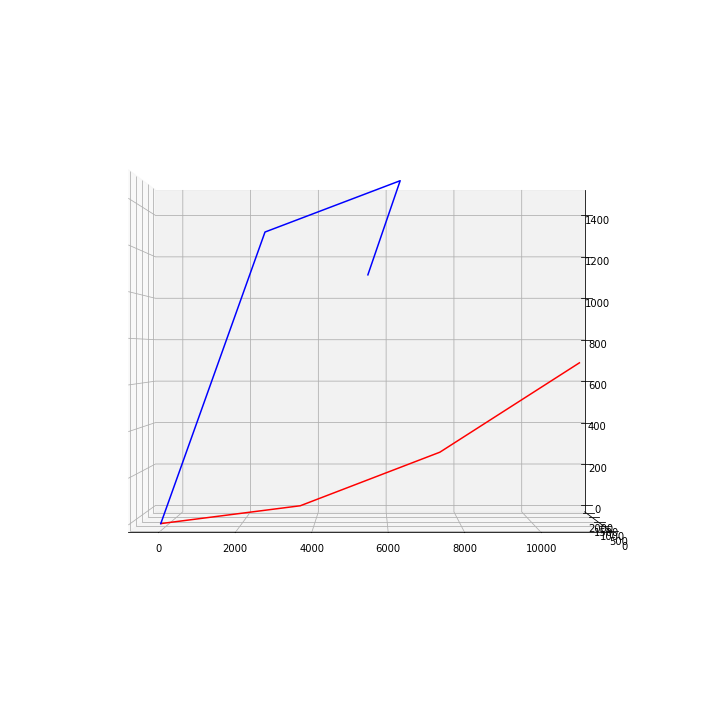

In [184]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]
# for j in range(len(fin.y.T)):
j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
ax.view_init(-30,-30)
ax.view_init(0,-90)
# ax.view_init(-90,-90)
# ax.set_xlim([0, 5])
# ax.set_ylim([0, 5])
plt.show()

In [185]:
X,Y,Z

(array([   0.        , 2714.98672716, 6332.06894318, 5461.68562211]),
 array([   0.        ,  247.6108493 ,  273.38875476, 2055.01345473]),
 array([   0.        , 1266.22514368, 1491.86815416, 1110.56205855]))

In [186]:
X0,Y0,Z0

(array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446]),
 array([0., 0., 0., 0.]),
 array([  0.        ,  77.06804645, 308.4070593 , 694.42189511]))

In [187]:
us=fin.T

In [188]:
# t=np.arange(tspan[0],tspan[1],tspan[1]/len(us.T))

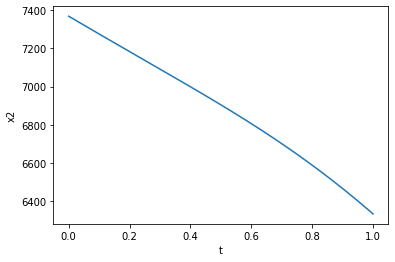

In [189]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

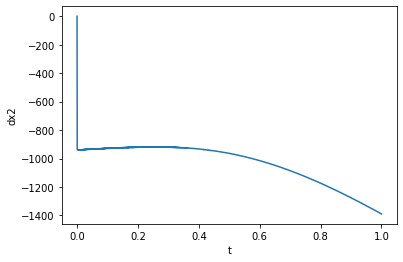

In [190]:
plt.plot(t,us.T[:,6] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

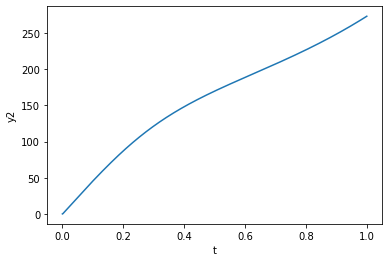

In [191]:
plt.plot(t,us.T[:,10] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

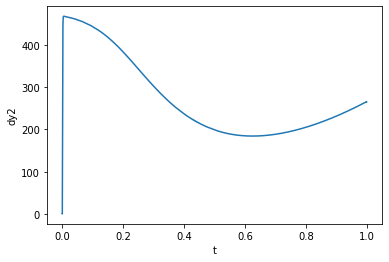

In [192]:
plt.plot(t,us.T[:,14] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

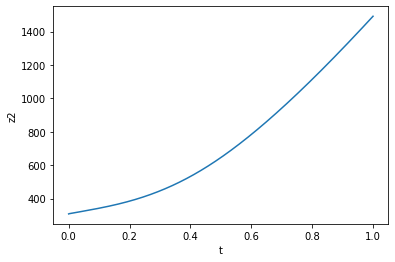

In [193]:
plt.plot(t,us.T[:,18] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

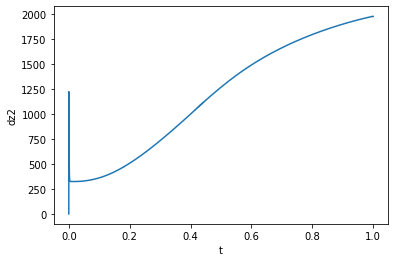

In [194]:
plt.plot(t,us.T[:,22] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

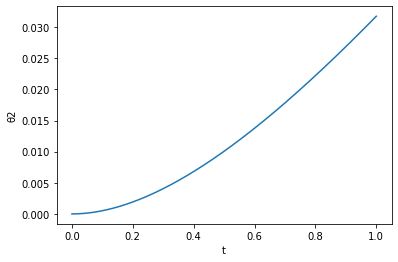

In [195]:
plt.plot(t,us.T[:,34],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

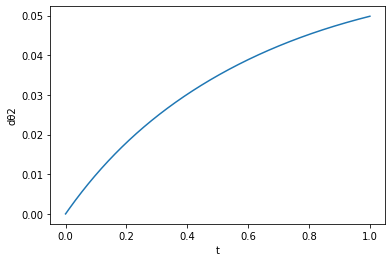

In [196]:
plt.plot(t,us.T[:,38] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

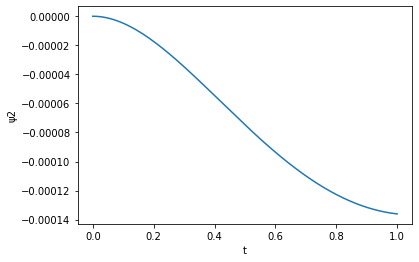

In [197]:
plt.plot(t,us.T[:,42],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

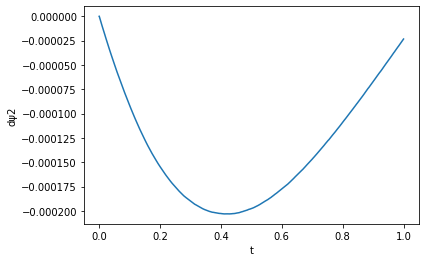

In [198]:
plt.plot(t,us.T[:,46] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()